# Analyze ROS2 Bag Files

Install the necessary libraries. You only need to run this cell once.

In [27]:
import glob
from pathlib import Path
import utils_exec_trajectory
data_dir = Path('.')
bag_dirs = [p.parent for p in data_dir.glob('dataset/run_*/*.mcap*')]
print(f"Found {len(bag_dirs)} bag directories.")
for bag_dir in bag_dirs:
    df_js, df_wrench = utils_exec_trajectory.read_rosbag(bag_dir)
    print(f"Processing {bag_dir.name}...")
    start_time, action_end_time, end_time = utils_exec_trajectory.get_start_time(df_js), utils_exec_trajectory.get_action_end_time(df_js), utils_exec_trajectory.get_settling_time(df_wrench)
    print(f"Start time: {start_time.time_sec}, Action end time: {action_end_time}, Settling time: {end_time.time_sec}")
    break

Found 100 bag directories.
Processing run_00040_20250821_171513...
Start time: 0.004980844, Action end time: 5.067315153, Settling time: 5.8713198250000005


In [38]:
def find_last_action_period(df_js, threshold=0.001, window_size=5):
    window_size = 6 * int(window_size) #  because we want to use all of the joints
    velocity_diff = df_js['velocity'].diff().abs()
    is_below_threshold = velocity_diff > threshold
    consecutive_count = is_below_threshold.rolling(window=window_size).sum()
    action_indices = consecutive_count[consecutive_count == window_size].index

    if not action_indices.empty:
        last_action_end_index = action_indices[-1]
        last_action_start_index = last_action_end_index - window_size + 1
        action_segment = df_js.loc[last_action_start_index:last_action_end_index]
        return action_segment.iloc[-1]['time_sec']
    else:
        return None

# Example usage with the existing variables from the notebook context
# This part is for demonstration and would typically be in a different cell.
# Assuming df_js_joint is defined as in the notebook context.
# For example:
# joint_name_to_analyze = df_js['joint_name'].unique()[0] 
# df_js_joint = df_js[df_js['joint_name'] == joint_name_to_analyze]

threshold = 0.001
window_size = 5
action_end_time = find_last_action_period(df_js, threshold, window_size)

if action_end_time is not None:
    print(f"Last sequence of {window_size} timesteps with velocity difference < {threshold} found.")
    print("\naction segment:")
    display(action_end_time)
else:
    print(f"No consecutive sequence of {window_size} timesteps found with velocity difference below {threshold}.")


Last sequence of 5 timesteps with velocity difference < 0.001 found.

action segment:


6.4404018590000005

In [ ]:
def get_action_segment(df_js, action_end_time):
    """
    Returns a DataFrame containing data only up to the action_end_time.
    If action_end_time is None, returns an empty DataFrame.
    """
    if action_end_time is not None:
        df_js_action = df_js[df_js['time_sec'] < action_end_time].copy()
        print(f"DataFrame 'df_js' trimmed to data before time {action_end_time:.4f}s.")
        display(df_js_action.tail())
        return df_js_action
    else:
        print("action_end_time is not defined. Cannot trim the DataFrame.")
        return pd.DataFrame()  # Create an empty dataframe



DataFrame 'df_js' trimmed to data before time 6.4404s.


time_sec           joint_name  position  velocity    effort
19387  6.438506  shoulder_lift_joint -0.787398 -0.019191 -5.403188
19388  6.438506   shoulder_pan_joint  0.001925  0.009655 -2.413312
19389  6.438506        wrist_1_joint -0.000460  0.014876 -0.632327
19390  6.438506        wrist_2_joint  0.783886  0.049520  0.850168
19391  6.438506        wrist_3_joint  1.570650  0.001410  0.171373

Start time: 0.00022486600000000003, Settling time: 7.970379033


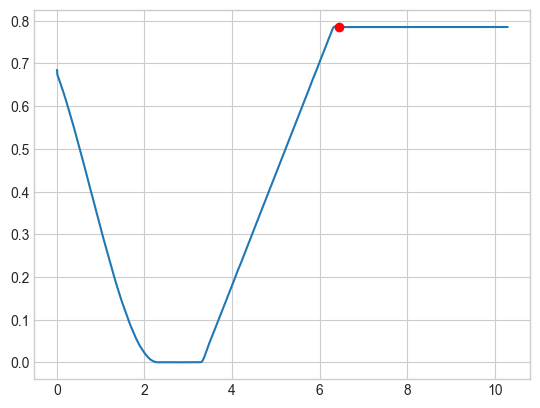

In [44]:
import utils
import matplotlib.pyplot as plt

df_js, df_wrench = utils.read_rosbag("/Users/test/Coding/ur_ws/sdu_ur_a/colcon_ws/data/baseline_runs/run_const_acc")
start, end = utils.get_start_time(df_js), utils.get_settling_time(df_wrench)
print(f"Start time: {start.time_sec}, Settling time: {end.time_sec}")

joint_name = df_js['joint_name'].unique()[0]
df_js_joint = df_js[df_js['joint_name'] == joint_name]
plt.plot(df_js_joint['time_sec'], df_js_joint['position'], label=joint_name)
# Find the index of the point in time closest to the settling time
closest_settling_idx = (df_js_joint['time_sec'] - action_end_time).abs().idxmin()
# Get the corresponding point
settling_point = df_js_joint.loc[closest_settling_idx]
# Plot the point as a red dot
plt.plot(settling_point['time_sec'], settling_point['position'], 'ro')
# for joint_name in df_js['joint_name'].unique():
#     df_js_joint = df_js[df_js['joint_name'] == joint_name]
#     plt.plot(df_js_joint['time_sec'], df_js_joint['position'], label=joint_name)
#     # Find the index of the point in time closest to the settling time
#     closest_settling_idx = (df_js_joint['time_sec'] - action_end_time).abs().idxmin()
#     # Get the corresponding point
#     settling_point = df_js_joint.loc[closest_settling_idx]
#     # Plot the point as a red dot
#     plt.plot(settling_point['time_sec'], settling_point['position'], 'ro')



In [1]:
import utils_exec_trajectory

In [5]:
def add_noise_to_via_points(model, t_plot, std=0.01):
    """
    Add noise to the via points of the model for visualization.
    The start and end points remain exact.
    """
    noise = np.random.normal(0, std, t_plot.shape)
    noise[0] = 0
    noise[-1] = 0
    return model["pos"](t_plot) + noise

DataFrame 'df_js' trimmed to data before time 6.4404s.


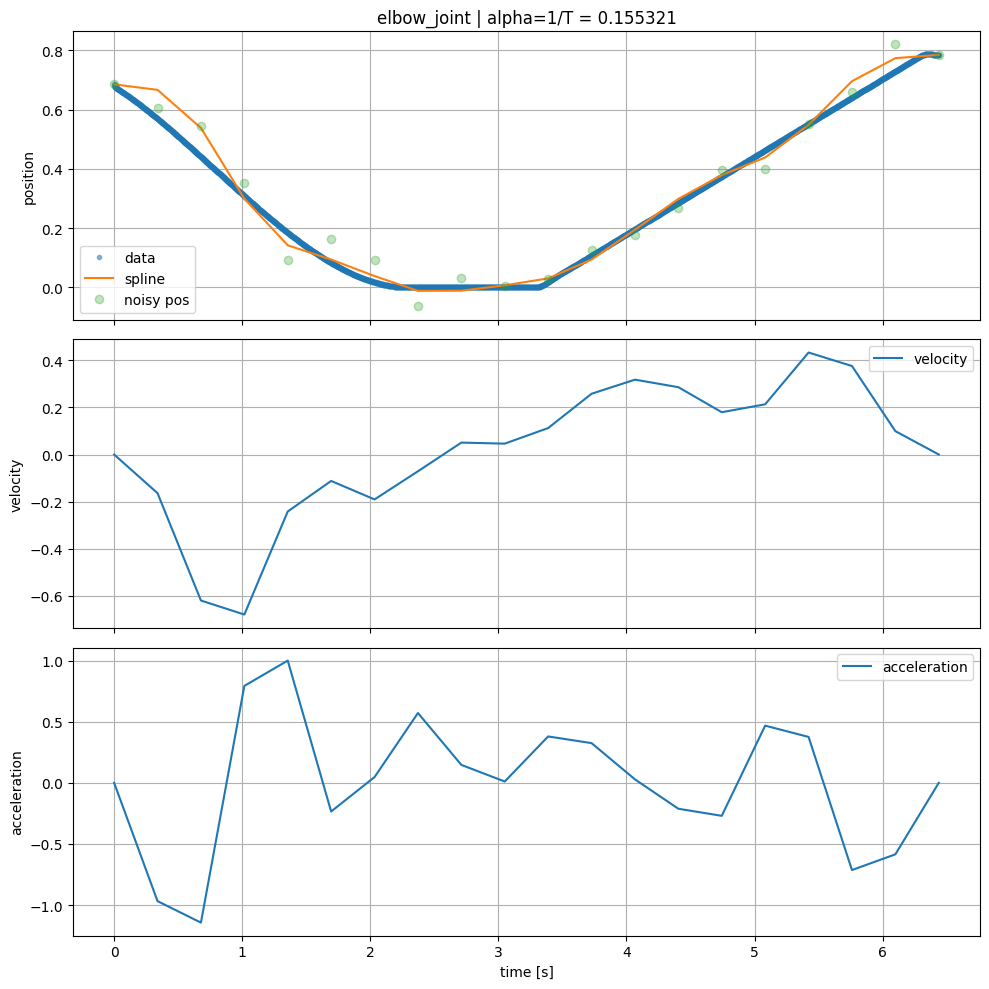

elbow_joint: v(0)=0.0, v(T)=4.409660227044861e-31, a(0)=0.0, a(T)=-1.2338290266041435e-15


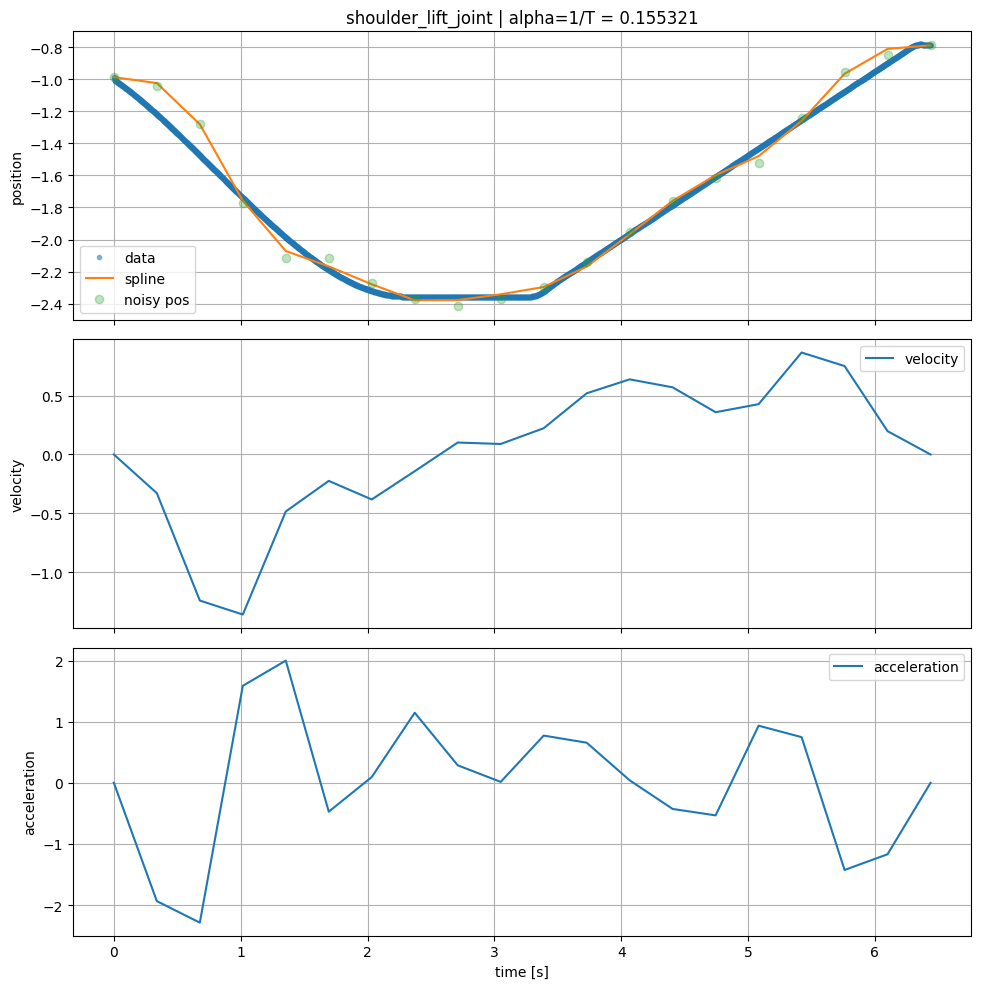

shoulder_lift_joint: v(0)=0.0, v(T)=8.811138501338025e-31, a(0)=0.0, a(T)=-2.465368731519184e-15


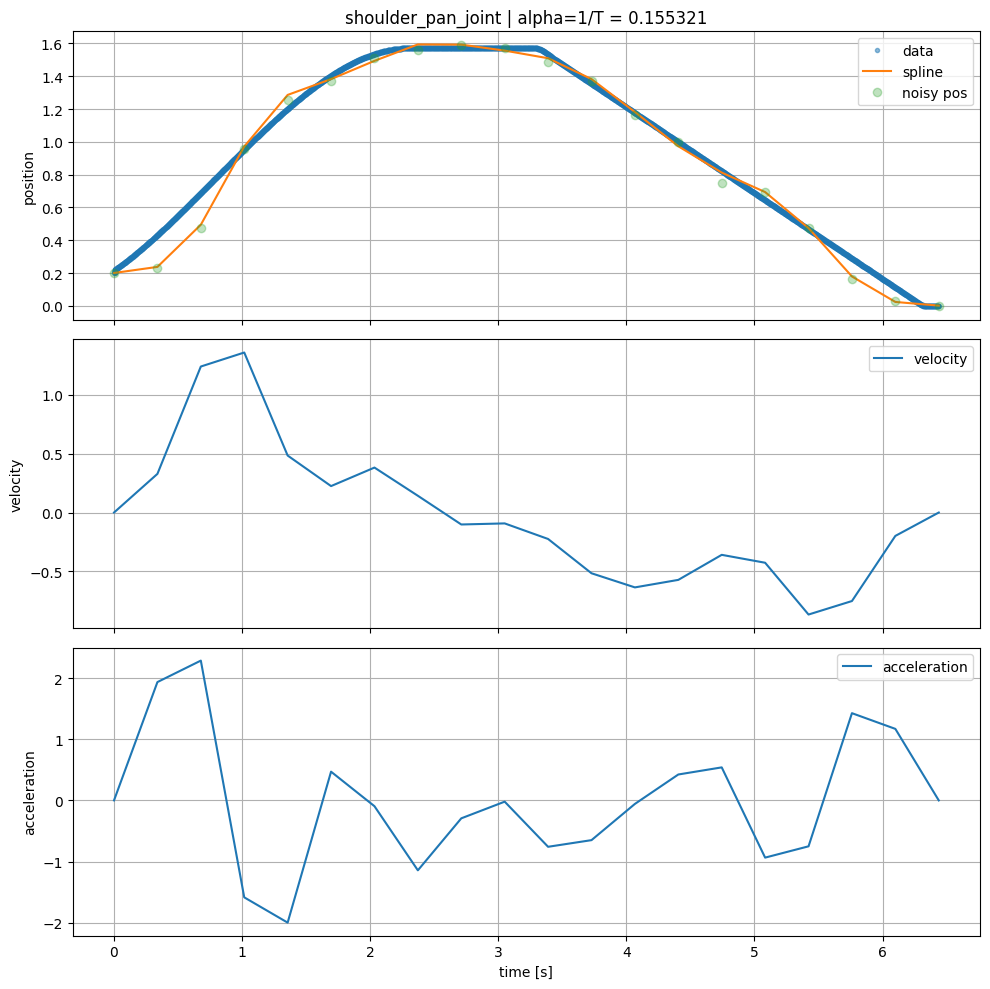

shoulder_pan_joint: v(0)=0.0, v(T)=-8.819152138939202e-31, a(0)=0.0, a(T)=2.4676109583965243e-15


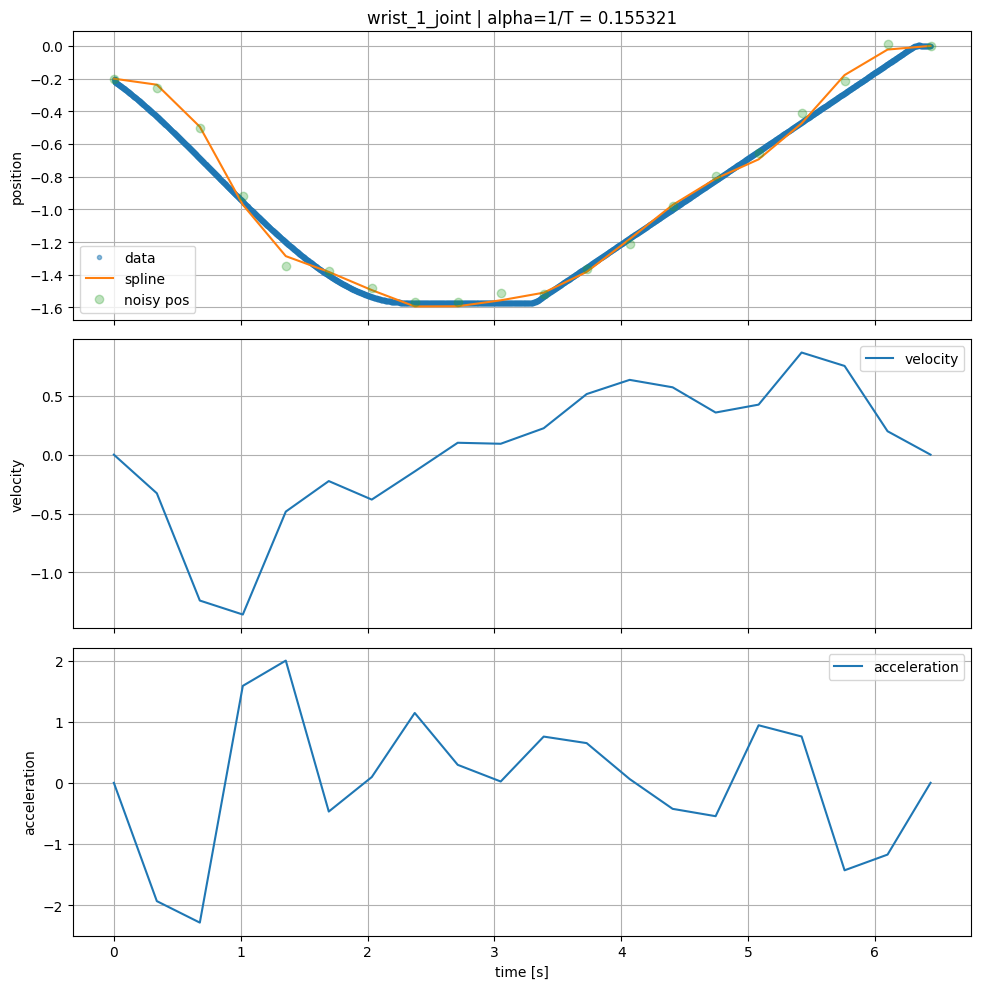

wrist_1_joint: v(0)=0.0, v(T)=8.850892421872303e-31, a(0)=0.0, a(T)=-2.476491933432946e-15


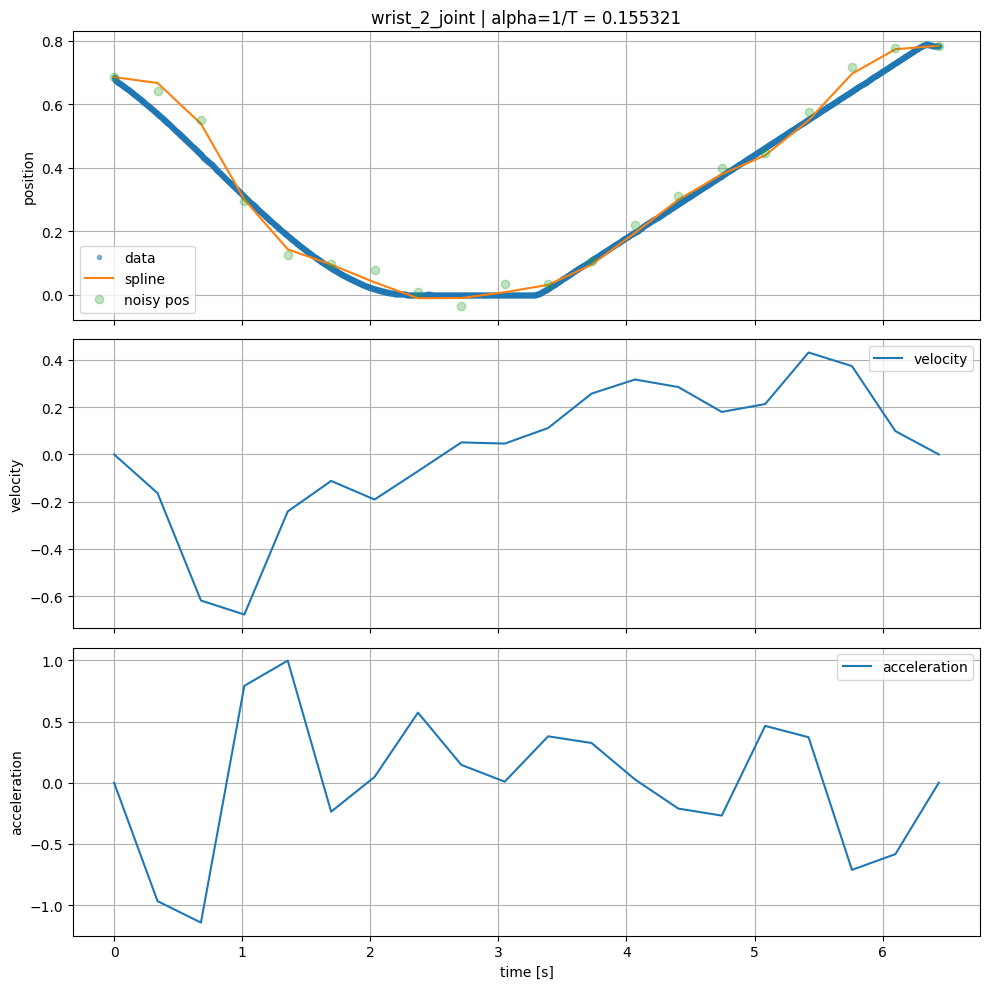

wrist_2_joint: v(0)=0.0, v(T)=4.396556368834316e-31, a(0)=0.0, a(T)=-1.2301625489645475e-15


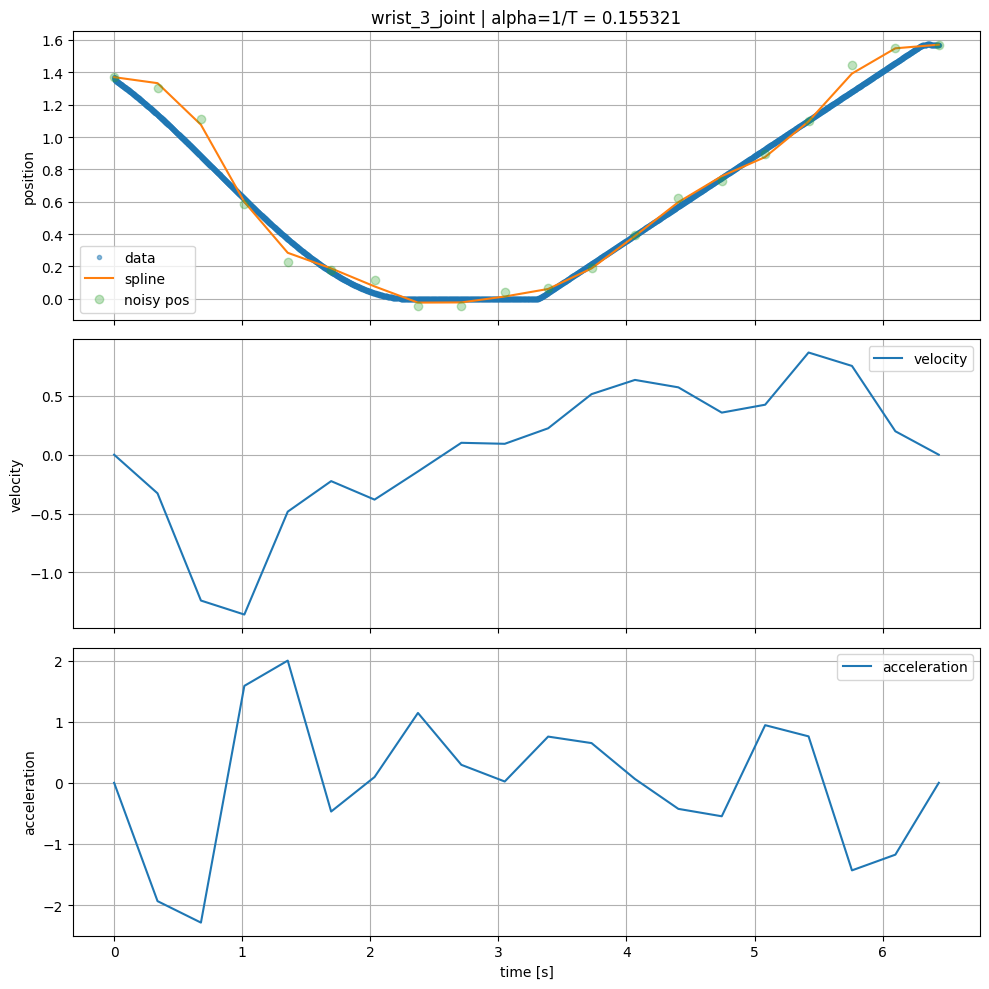

wrist_3_joint: v(0)=0.0, v(T)=8.858592314196837e-31, a(0)=0.0, a(T)=-2.47864637394822e-15
Noisy positions array shape: (120,)


In [2]:
import numpy as np
from scipy.interpolate import BSpline
import matplotlib.pyplot as plt

def fit_clamped_bspline_zero_end_va(t_real, y, *, degree=3, n_internal_knots=8):

    p = degree
    if p != 3:
        raise ValueError("This helper assumes cubic splines (degree=3) for zero vel/acc tying.")
    if n_internal_knots < 3:
        raise ValueError("n_internal_knots must be >= 3 so there are free control points.")

    t_real = np.asarray(t_real, dtype=float)
    y = np.asarray(y, dtype=float)

    # Drop NaNs/Infs and sort by time
    m = np.isfinite(t_real) & np.isfinite(y)
    t_real = t_real[m]; y = y[m]
    order = np.argsort(t_real)
    t_real = t_real[order]; y = y[order]

    if len(t_real) < p + 3:
        raise ValueError("Not enough samples to fit a cubic spline.")

    t0 = t_real[0]
    t1 = t_real[-1]
    T = float(t1 - t0)
    if T <= 0:
        raise ValueError("Time vector must span a positive duration.")
    alpha = 1.0 / T

    # Normalize to u in [0,1]
    u_data = (t_real - t0) * alpha

    # Open/clamped knot vector on [0,1]
    if n_internal_knots > 0:
        knots_internal = np.linspace(0, 1, n_internal_knots + 2)[1:-1]
    else:
        knots_internal = np.array([], dtype=float)
    t = np.r_[np.zeros(p+1), knots_internal, np.ones(p+1)]  # length K + 2(p+1)

    n_ctrl = len(t) - p - 1  # = n_internal_knots + p + 1 = n_internal_knots + 4 (for cubic)

    # Build basis matrix at data u positions
    def basis_col(j):
        coeff = np.zeros(n_ctrl); coeff[j] = 1.0
        return BSpline(t, coeff, p)(u_data)

    A = np.column_stack([basis_col(j) for j in range(n_ctrl)])

    # Tie first three and last three control points to start/end value
    start, end = y[0], y[-1]
    fixed_idx = [0, 1, 2, n_ctrl-3, n_ctrl-2, n_ctrl-1]
    free_idx  = [j for j in range(n_ctrl) if j not in fixed_idx]

    P_fixed = np.array([start, start, start, end, end, end], dtype=float)
    A_fixed = A[:, fixed_idx]
    A_free  = A[:, free_idx]
    rhs = y - A_fixed @ P_fixed

    # Least squares for free control points
    P_free, *_ = np.linalg.lstsq(A_free, rhs, rcond=None)

    # Assemble control points
    P = np.empty(n_ctrl)
    P[fixed_idx] = P_fixed
    P[free_idx]  = P_free

    # Spline in u-domain and its derivatives
    spline_u = BSpline(t, P, p)
    s1_u = spline_u.derivative(1)
    s2_u = spline_u.derivative(2)

    # Real-time callables with chain rule
    def pos(t_query):
        tq = np.asarray(t_query, dtype=float)
        u = (tq - t0) * alpha
        return spline_u(u)

    def vel(t_query):
        tq = np.asarray(t_query, dtype=float)
        u = (tq - t0) * alpha
        return alpha * s1_u(u)

    def acc(t_query):
        tq = np.asarray(t_query, dtype=float)
        u = (tq - t0) * alpha
        return (alpha**2) * s2_u(u)

    return dict(
        pos=pos, vel=vel, acc=acc,
        t0=t0, T=T, alpha=alpha,
        spline_u=spline_u, s1_u=s1_u, s2_u=s2_u,
        knots=t, ctrl=P
    )


if __name__ == "__main__":
    # Your utils

    bag_path = "/Users/test/Coding/ur_ws/sdu_ur_a/colcon_ws/data/baseline_runs/run_const_acc"
    df_js, df_wrench = utils_exec_trajectory.read_rosbag(bag_path)

    # Sanity: expect columns joint_name, time_sec, position
    if not {"joint_name", "time_sec", "position"}.issubset(df_js.columns):
        raise RuntimeError("df_js must have columns: joint_name, time_sec, position")


    start_time,action_end_time,end_time = utils_exec_trajectory.get_start_time(df_js),utils_exec_trajectory.get_action_end_time(df_js), utils_exec_trajectory.get_settling_time(df_wrench)
    df_js_action= utils_exec_trajectory.get_action_segment(df_js, action_end_time)

    joint_models = {}

    noisy_joint_pos_arr = []
    for joint_name, df_joint in df_js_action.groupby("joint_name"):
        t = df_joint["time_sec"].to_numpy()
        y = df_joint["position"].to_numpy()

        model = utils_exec_trajectory.fit_clamped_bspline_zero_end_va(
            t, y, degree=3, n_internal_knots=10  # adjust knots if you want smoother/rougher
        )
        joint_models[joint_name] = model

        # Fine grid in REAL time for plotting
        t_plot = np.linspace(t.min(), t.max(), 20)

        noised_pos = utils_exec_trajectory.add_noise_to_via_points(model, t_plot,std=0.03)  # Add noise for visualization

        noisy_joint_pos_arr.append(noised_pos)
        # Position / Velocity / Acceleration plots (real time)
        fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
        axs[0].plot(t, y, ".", alpha=0.5, label="data")
        axs[0].plot(t_plot, model["pos"](t_plot), "-", label="spline")
        axs[0].plot(t_plot, noised_pos, "o", alpha=0.3, label="noisy pos")
        axs[0].set_ylabel("position")
        axs[0].grid(True); axs[0].legend()
        axs[0].set_title(f"{joint_name} | alpha=1/T = {model['alpha']:.6g}")

        axs[1].plot(t_plot, model["vel"](t_plot), "-", label="velocity")
        axs[1].set_ylabel("velocity")
        axs[1].grid(True); axs[1].legend()

        axs[2].plot(t_plot, model["acc"](t_plot), "-", label="acceleration")
        axs[2].set_xlabel("time [s]"); axs[2].set_ylabel("acceleration")
        axs[2].grid(True); axs[2].legend()

        plt.tight_layout()
        plt.show()

        # Quick numeric check at endpoints in REAL time
        v0 = model["vel"](model["t0"])
        v1 = model["vel"](model["t0"] + model["T"])
        a0 = model["acc"](model["t0"])
        a1 = model["acc"](model["t0"] + model["T"])
        print(f"{joint_name}: v(0)={v0}, v(T)={v1}, a(0)={a0}, a(T)={a1}")
    noised_pos_arr = np.array(noisy_joint_pos_arr).flatten()
    print("Noisy positions array shape:", noised_pos_arr.shape)


In [12]:
%pip install scikit-optimize

  Using cached scikit_optimize-0.10.2-py2.py3-none-any.whl.metadata (9.7 kB)
  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_optimize-0.10.2-py2.py3-none-any.whl (107 kB)
Using cached joblib-1.5.1-py3-none-any.whl (307 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 43.3 MB/s eta 0:00:0000:01
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [scikit-optimize] [scikit-learn]
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
from typing import Callable, Tuple, Optional, List, Dict, Any
from skopt import Optimizer
from skopt.space import Real

def run_bayes_search(
    objective: Callable[[np.ndarray], float],
    X_init: Optional[np.ndarray] = None,
    y_init: Optional[np.ndarray] = None,
    *,
    n_iter: int = 50,
    batch_size: int = 1,
    bounds: Tuple[float, float] = (0.0, 1.0),
    base_estimator: str = "GP",
    acq_func: str = "EI",
    random_state: int = 0,
    verbose: bool = True,
) -> Tuple[np.ndarray, float, Optimizer, List[Dict[str, Any]]]:
    """
    Bayesian optimization with warm start that logs losses as it goes.

    Returns:
      best_x, best_y, opt, history

    history = list of dicts per iteration:
      {
        'iter': int,
        'batch_X': np.ndarray (batch_size, 120),
        'batch_y': np.ndarray (batch_size,),
        'incumbent_y': float,      # best so far after this iteration
        'incumbent_x': np.ndarray  # 120-dim best so far
      }
    """
    low, high = bounds
    space = [Real(low, high, name=f"x{i}") for i in range(120)]
    opt = Optimizer(dimensions=space, base_estimator=base_estimator,
                    acq_func=acq_func, random_state=random_state)

    # Warm start
    if X_init is not None and y_init is not None:
        X_init = np.asarray(X_init, dtype=float)
        y_init = np.asarray(y_init, dtype=float).ravel()
        if X_init.ndim != 2 or X_init.shape[1] != 120:
            raise ValueError("X_init must have shape (n0, 120)")
        if y_init.shape[0] != X_init.shape[0]:
            raise ValueError("y_init length must match X_init rows")
        if not (np.all(X_init >= low) and np.all(X_init <= high)):
            raise ValueError("Some initial points are out of bounds")
        opt.tell(list(map(list, X_init)), list(map(float, y_init)))

    history: List[Dict[str, Any]] = []

    # BO loop
    for it in range(1, n_iter + 1):
        asks: List[List[float]] = opt.ask(n_points=batch_size)
        ys = [float(objective(np.array(x))) for x in asks]
        opt.tell(asks, ys)

        # Incumbent (best so far)
        yi = np.array(opt.yi, float)
        Xi = np.array(opt.Xi, float)
        best_idx = int(np.argmin(yi))
        incumbent_y = float(yi[best_idx])
        incumbent_x = Xi[best_idx].copy()

        # Log
        if verbose:
            if batch_size == 1:
                print(f"[{it:03d}] y={ys[0]:.6f} | best={incumbent_y:.6f}")
            else:
                batch_str = ", ".join(f"{v:.6f}" for v in ys)
                print(f"[{it:03d}] batch_y=[{batch_str}] | best={incumbent_y:.6f}")

        # Save to history
        history.append({
            "iter": it,
            "batch_X": np.array(asks, float),
            "batch_y": np.array(ys, float),
            "incumbent_y": incumbent_y,
            "incumbent_x": incumbent_x,
        })

    # Final best
    best_x = history[-1]["incumbent_x"]
    best_y = history[-1]["incumbent_y"]
    return best_x, best_y, opt, history


In [ ]:
# bayes_120d.py
import numpy as np
from typing import Callable, Tuple, Optional, List
from skopt import Optimizer
from skopt.space import Real

# ------------------------------------------------------------
# 1) Your objective: takes a 120-element array, returns a number
#    Replace this with your real evaluation.
# ------------------------------------------------------------
def score(x: np.ndarray) -> float:
    """
    Example objective: Shifted Sphere (you MUST replace this).
    x: shape (120,)
    return: scalar loss (minimize)
    """
    x = np.asarray(x, dtype=float).ravel()

    # execute x
    # open the rosbag to get the settling time

    assert x.size == 120, "score(x) expects a 120-D vector"
    # Example: minimum near 0.3 (inside [0,1] box)
    return float(np.sum((x - 0.3)**2)) # return settling time 




# ------------------------------------------------------------
# 3) Example usage
#    Replace X_init / y_init with your collected data
# ------------------------------------------------------------
if __name__ == "__main__":
    # (A) Example: fabricate some initial data you collected elsewhere
    #     Replace this block with your real data loading.
    rng = np.random.default_rng(42)
    n0 = 20  # number of warm-start points you already have
    X_init = rng.uniform(0.0, 1.0, size=(n0, 120))
    y_init = np.array([score(x) for x in X_init], dtype=float)  # you should already have these

    # (B) Run Bayesian optimization
    best_x, best_y, opt, hist = run_bayes_search(
        objective=score,            # <-- plug your own function here
        X_init=X_init,              # <-- your collected inputs (n0,120)
        y_init=y_init,              # <-- their evaluated scores (n0,)
        n_iter=1,                  # additional BO iterations
        batch_size=4,               # suggest 4 points per iteration
        bounds=(0.0, 1.0),          # change if your variables have different ranges
        base_estimator="ET",        # "ET" (extra-trees) handles 120D well; try "RF" too
        acq_func="EI",
        random_state=0
    )

    print("Best value found:", best_y)
    print("Best x (first 10 dims):", np.round(best_x[:10], 4), "... (total 120 dims)")
    # Full history is in opt.Xi (inputs) and opt.yi (scores)


[001] batch_y=[16.665075, 13.925219, 17.018554, 12.869557] | best=12.869557
Best value found: 12.869557110808833
Best x (first 10 dims): [0.073  0.3067 0.4751 0.2001 0.9672 0.3209 0.6    0.1933 0.741  0.4182] ... (total 120 dims)


v(0)= 0.0  a(0)= 0.0
v(1)= 0.0  a(1)= 0.0


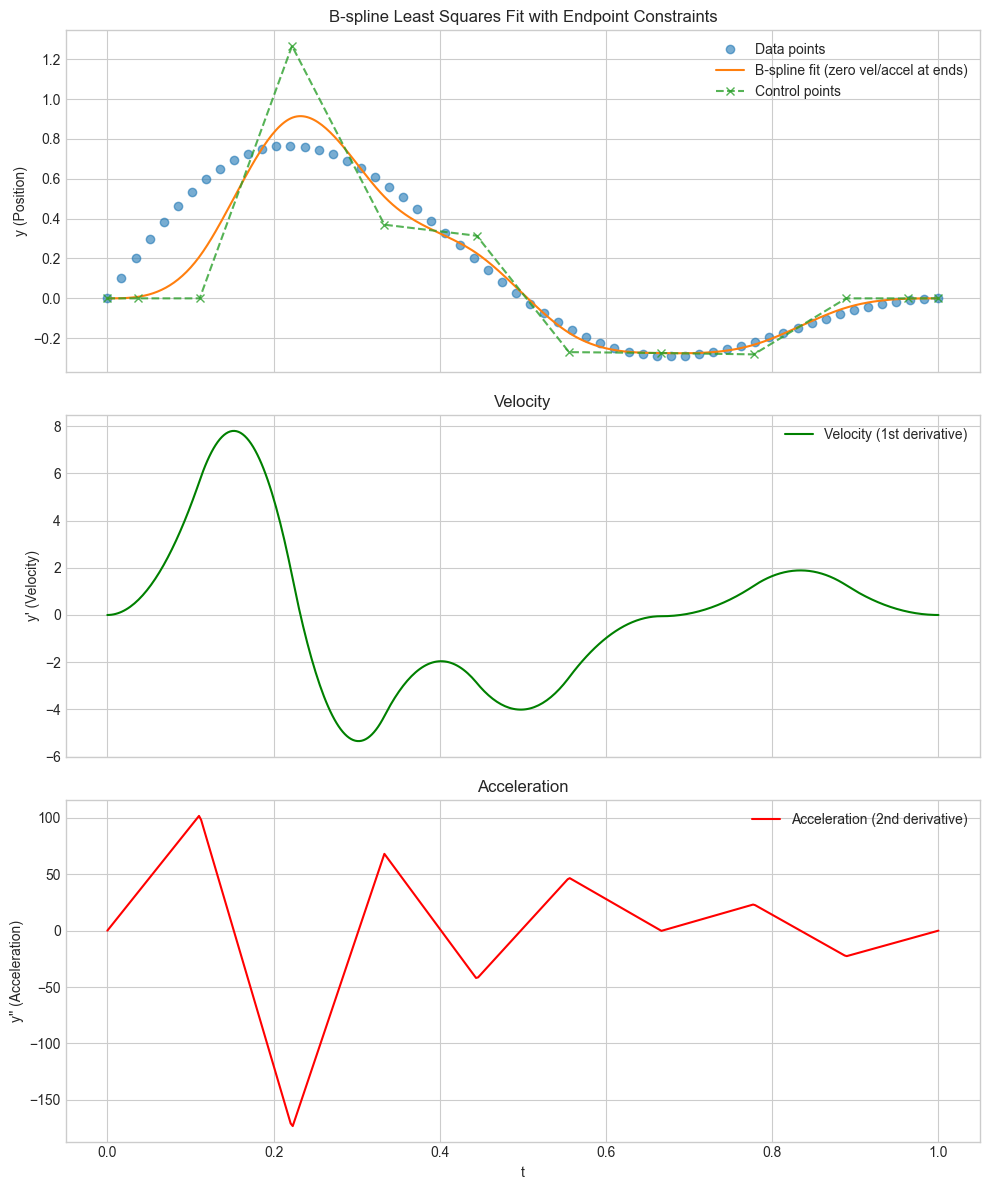

In [ ]:
import numpy as np
from scipy.interpolate import BSpline

# Sample data (t in [0,1], y some measurements)
t_data = np.linspace(0, 1, 60)
y_data = np.sin(2*np.pi*t_data) * (1 - t_data)  # any data; endpoints near 0
start, end = y_data[0], y_data[-1]

p = 3  # cubic (C^2 continuous)

# Choose number of internal knots / control points
n_internal_knots = 8
knots_internal = np.linspace(0, 1, n_internal_knots+2)[1:-1]  # exclude 0 and 1
# Open (clamped) knot vector
t = np.r_[np.zeros(p+1), knots_internal, np.ones(p+1)]
n_ctrl = len(t) - p - 1

# Build basis matrix A for all control points at sample parameters
# (SciPy doesn’t give the whole matrix directly; evaluate each basis by unit vectors)
def basis_column(j):
    coeff = np.zeros(n_ctrl); coeff[j] = 1.0
    return BSpline(t, coeff, p)(t_data)

A = np.column_stack([basis_column(j) for j in range(n_ctrl)])

# Fix the first three and last three control points equal to start/end
fixed_idx = [0,1,2, n_ctrl-3, n_ctrl-2, n_ctrl-1]
free_idx  = [j for j in range(n_ctrl) if j not in fixed_idx]

P_fixed = np.array([start, start, start, end, end, end])
A_fixed = A[:, fixed_idx]
A_free  = A[:, free_idx]

# Right-hand side after removing fixed contributions
rhs = y_data - A_fixed @ P_fixed

# Solve least squares for remaining control points
P_free, *_ = np.linalg.lstsq(A_free, rhs, rcond=None)

# Reassemble full control-point vector
P = np.empty(n_ctrl)
P[fixed_idx] = P_fixed
P[free_idx]  = P_free

# Build spline and its derivatives
spline = BSpline(t, P, p)
s1 = spline.derivative(1)
s2 = spline.derivative(2)

# Check endpoint derivatives
print("v(0)=", s1(0.0), " a(0)=", s2(0.0))
print("v(1)=", s1(1.0), " a(1)=", s2(1.0))

import matplotlib.pyplot as plt

# Plot the results
fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Plot 1: Position
axs[0].plot(t_data, y_data, 'o', label='Data points', alpha=0.6)
t_fine = np.linspace(0, 1, 400)
y_fine = spline(t_fine)
axs[0].plot(t_fine, y_fine, label='B-spline fit (zero vel/accel at ends)')
ctrl_x = np.array([np.mean(t[i+1:i+p+1]) for i in range(n_ctrl)])
axs[0].plot(ctrl_x, P, 'x--', label='Control points', alpha=0.8)
axs[0].set_title("B-spline Least Squares Fit with Endpoint Constraints")
axs[0].set_ylabel("y (Position)")
axs[0].grid(True)
axs[0].legend()

# Plot 2: Velocity
v_fine = s1(t_fine)
axs[1].plot(t_fine, v_fine, 'g-', label='Velocity (1st derivative)')
axs[1].set_title("Velocity")
axs[1].set_ylabel("y' (Velocity)")
axs[1].grid(True)
axs[1].legend()

# Plot 3: Acceleration
a_fine = s2(t_fine)
axs[2].plot(t_fine, a_fine, 'r-', label='Acceleration (2nd derivative)')
axs[2].set_title("Acceleration")
axs[2].set_xlabel("t")
axs[2].set_ylabel("y'' (Acceleration)")
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()
plt.show()

In [ ]:
%pip install rosbags zstandard pandas pyyaml plotly matplotlib

Import the required libraries.

In [1]:
import os
import pandas as pd
from rosbags.rosbag2 import Reader
from rosbags.serde import deserialize_cdr
import yaml
from pathlib import Path
import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
data_dir = Path('.')
bag_dirs = [p.parent for p in data_dir.glob('run_*/*.mcap*')]
print(f"Found {len(bag_dirs)} bag directories.")

Found 13 bag directories.


In [ ]:
df_wrench.plot(x='time_sec', y='force_x_filtered', title='Force')
df_wrench.plot(x='time_sec', y='force_y_filtered', title='Force Y')
df_wrench.plot(x='time_sec', y='force_z_filtered', title='Force Z')

In [5]:
end

In [6]:
df_wrench

time_sec                                    topic   force_x   force_y  \
0      0.000000  /force_torque_sensor_broadcaster/wrench -0.952871 -0.656106   
1      0.000098  /force_torque_sensor_broadcaster/wrench -0.924690 -0.784866   
2      0.000114  /force_torque_sensor_broadcaster/wrench -0.508964 -0.895996   
3      0.000154  /force_torque_sensor_broadcaster/wrench -0.379286 -0.729688   
4      0.000199  /force_torque_sensor_broadcaster/wrench -0.243832 -0.926132   
...         ...                                      ...       ...       ...   
6234  12.411140  /force_torque_sensor_broadcaster/wrench  0.018958  0.413367   
6235  12.413013  /force_torque_sensor_broadcaster/wrench -0.759441  0.116127   
6236  12.415109  /force_torque_sensor_broadcaster/wrench  0.180899 -0.004262   
6237  12.417105  /force_torque_sensor_broadcaster/wrench -0.552539 -0.222412   
6238  12.419349  /force_torque_sensor_broadcaster/wrench -0.031083  0.306674   

       force_z  torque_x  torque_y  torque_z  force_x_filtered  \
0     0.855508  0.010323 -0.035220  0.034403         -0.945324   
1     0.869374  0.031621 -0.022745  0.021287         -0.901824   
2     1.066664  0.050476 -0.035428  0.009514         -0.859268   
3     1.051111  0.062040 -0.029321  0.002967         -0.818254   
4     1.386556  0.073443 -0.024424 -0.002177         -0.779311   
...        ...       ...       ...       ...               ...   
6234  0.122009 -0.009050  0.005699  0.005235         -0.125177   
6235  0.226420 -0.015257  0.026065  0.007839         -0.118462   
6236  0.104296 -0.020654  0.006724  0.007006         -0.111553   
6237  0.143196 -0.026388  0.020997  0.009822         -0.104638   
6238  0.156453 -0.014427  0.008611 -0.000305         -0.097940   

      force_y_filtered  force_z_filtered  force_var  
0            -0.558087          0.885113        NaN  
1            -0.600471          0.920045        NaN  
2            -0.639125          0.951118        NaN  
3            -0.673457          0.977535        NaN  
4            -0.702917          0.998515        NaN  
...                ...               ...        ...  
6234          0.124104          0.158868   0.012306  
6235          0.138435          0.158437   0.012405  
6236          0.152049          0.158081   0.012534  
6237          0.164779          0.157796   0.012695  
6238          0.176424          0.157573   0.012889  

[6239 rows x 12 columns]

In [8]:
start

time_sec              0.0
joint_name    elbow_joint
position         1.956207
velocity             -0.0
effort          -3.700614
Name: 0, dtype: object

Processing run_20250816_181459...


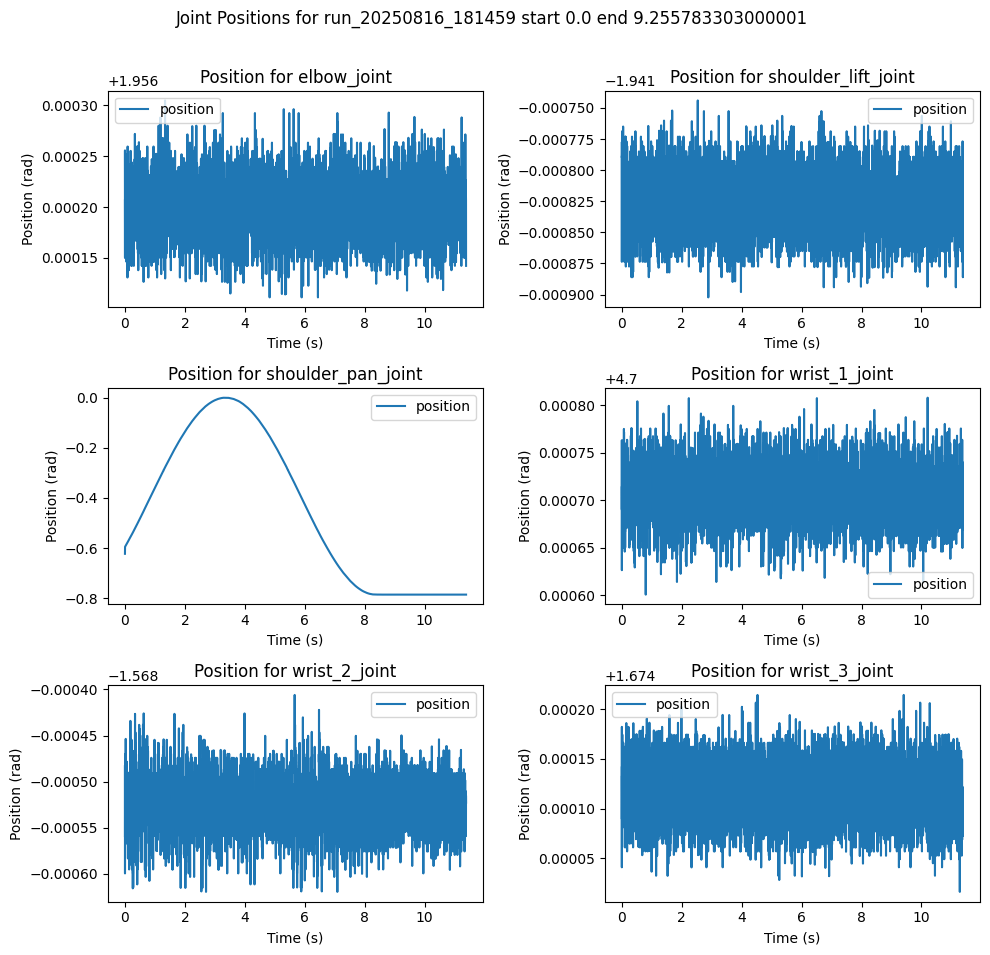

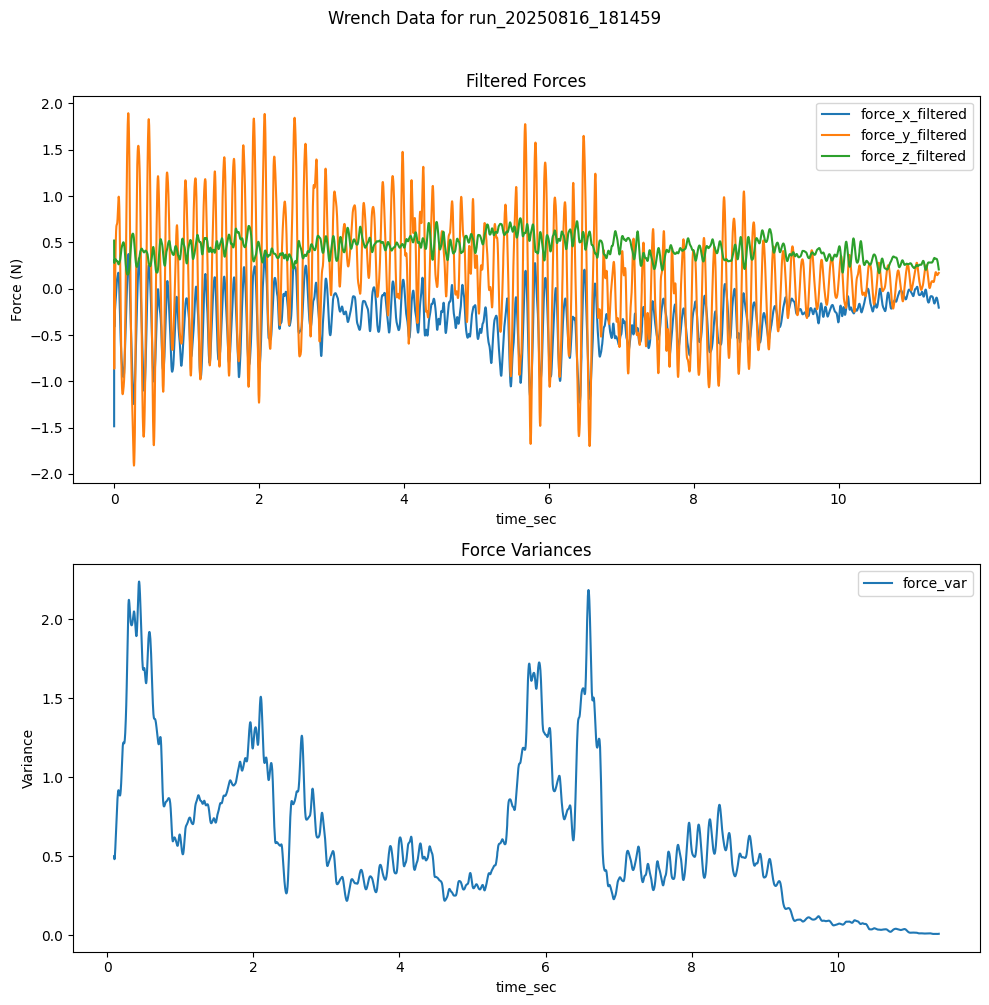

Processing run_20250816_180719...
No points found with variance above 0.2.
Skipping run_20250816_180719 due to missing start or end time.
Processing run_20250816_180141...
No points found with variance above 0.2.
Skipping run_20250816_180141 due to missing start or end time.
Processing run_20250816_180919...
No points found with variance above 0.2.
Skipping run_20250816_180919 due to missing start or end time.
Processing run_20250816_181125...
No points found with variance above 0.2.
Skipping run_20250816_181125 due to missing start or end time.
Processing run_20250816_181320...


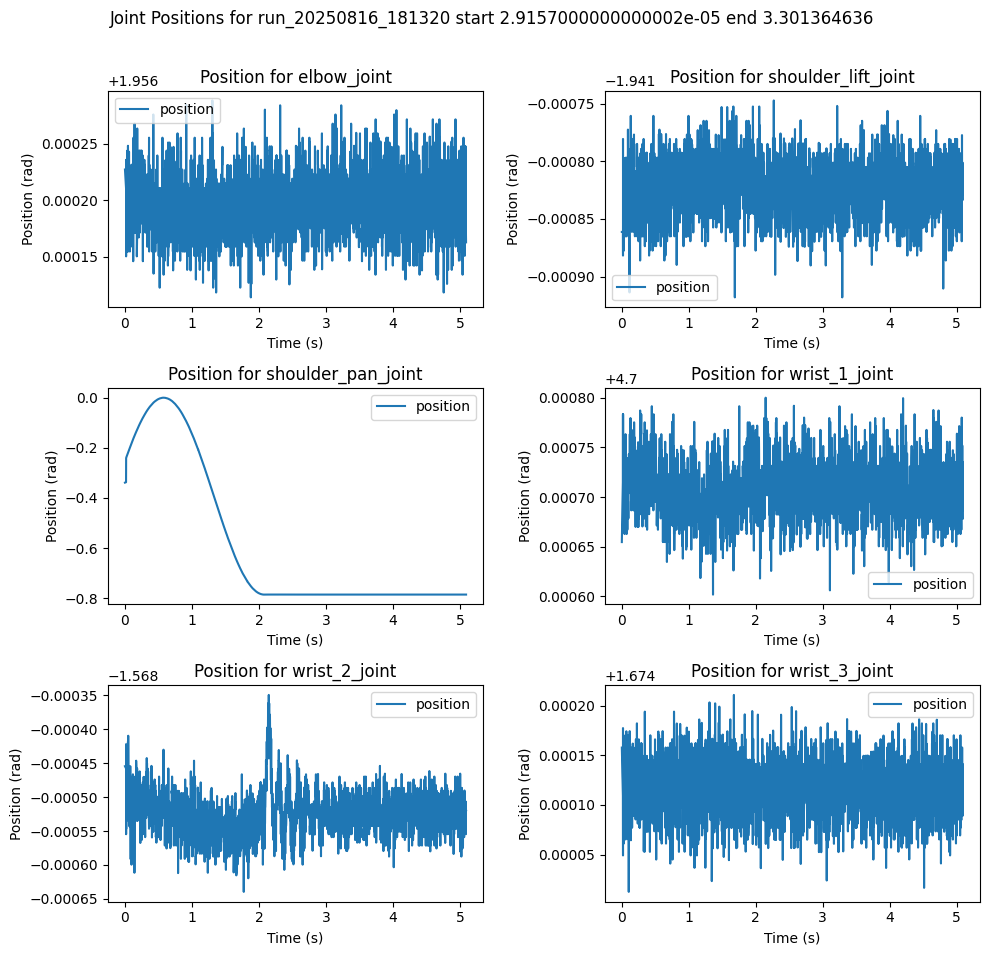

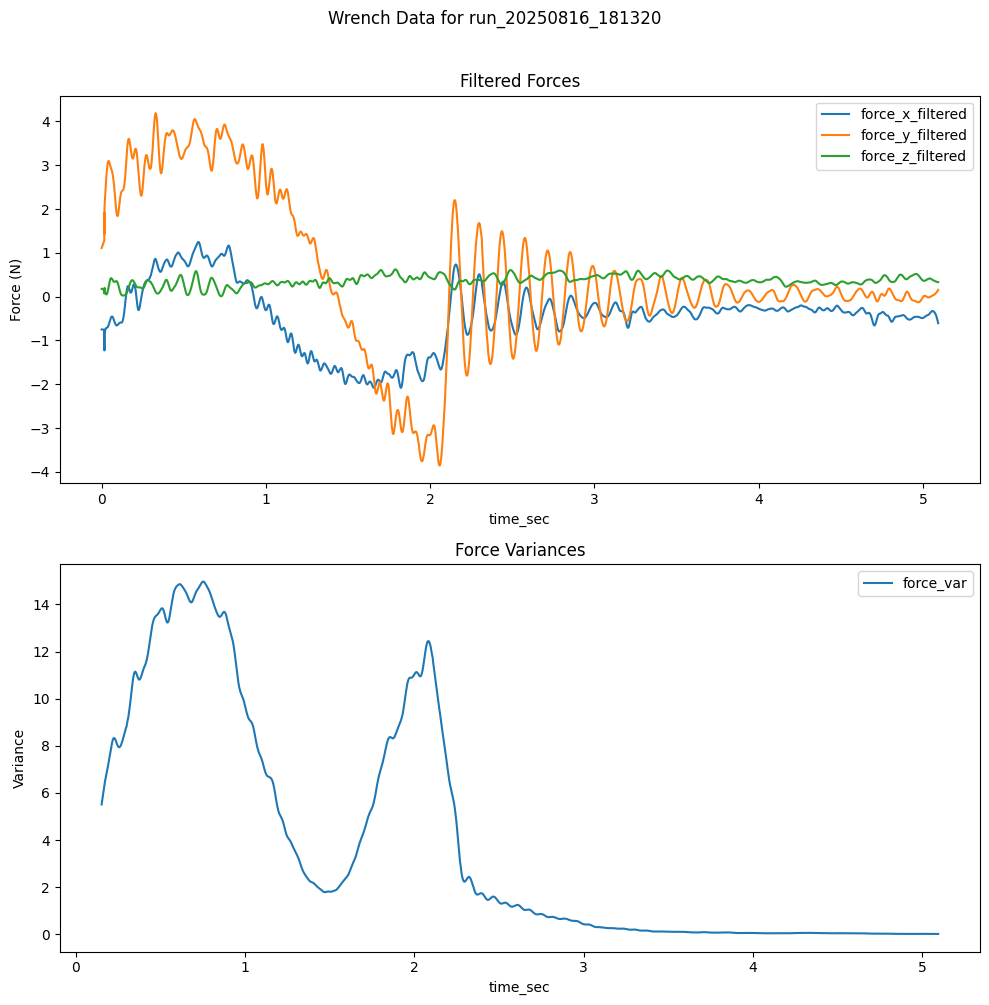

Processing run_20250816_174409...
No points found with variance above 0.2.
Skipping run_20250816_174409 due to missing start or end time.
Processing run_20250818_061834...


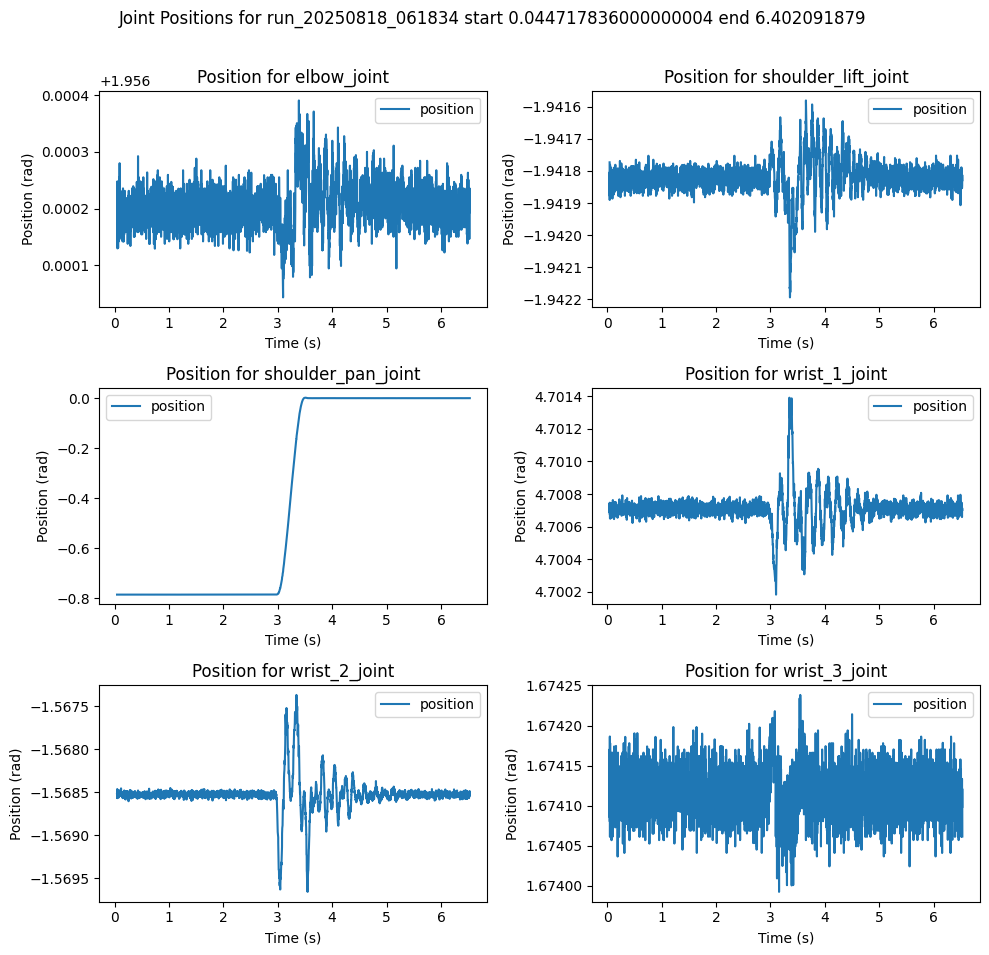

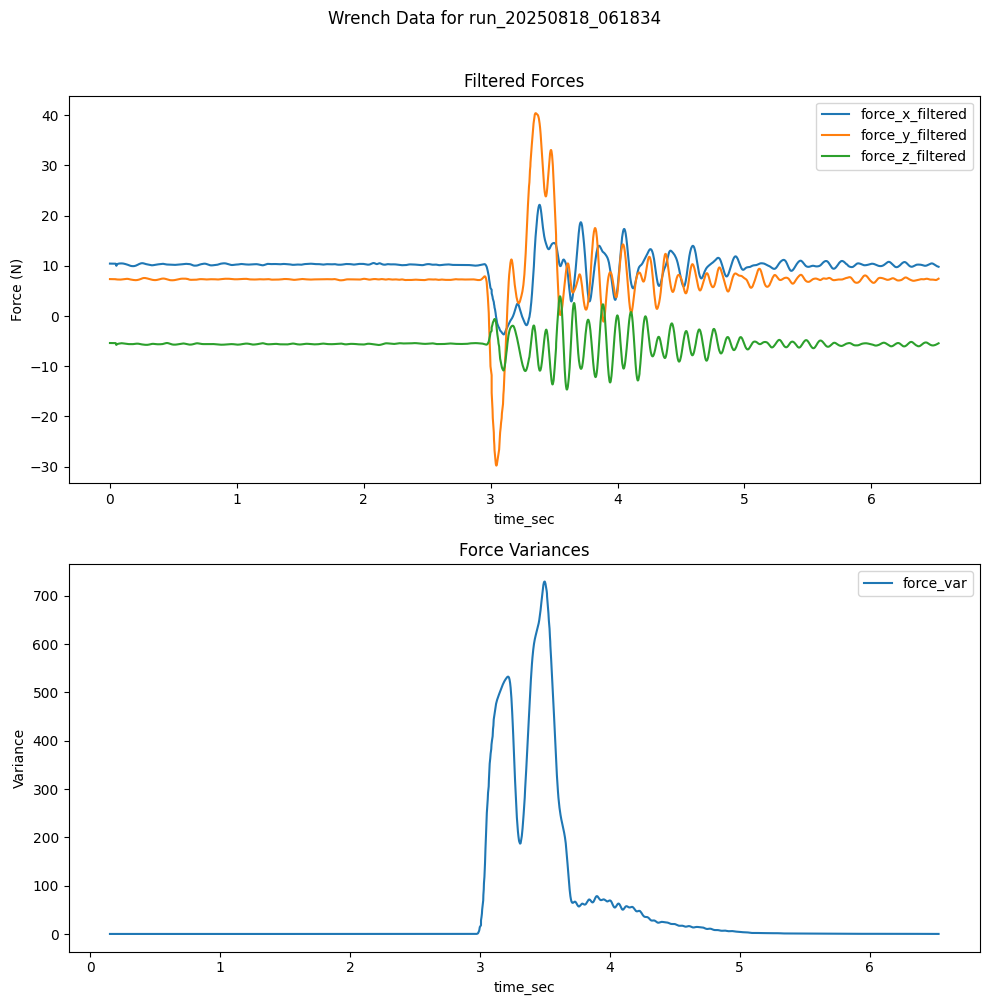

Processing run_20250816_181436...


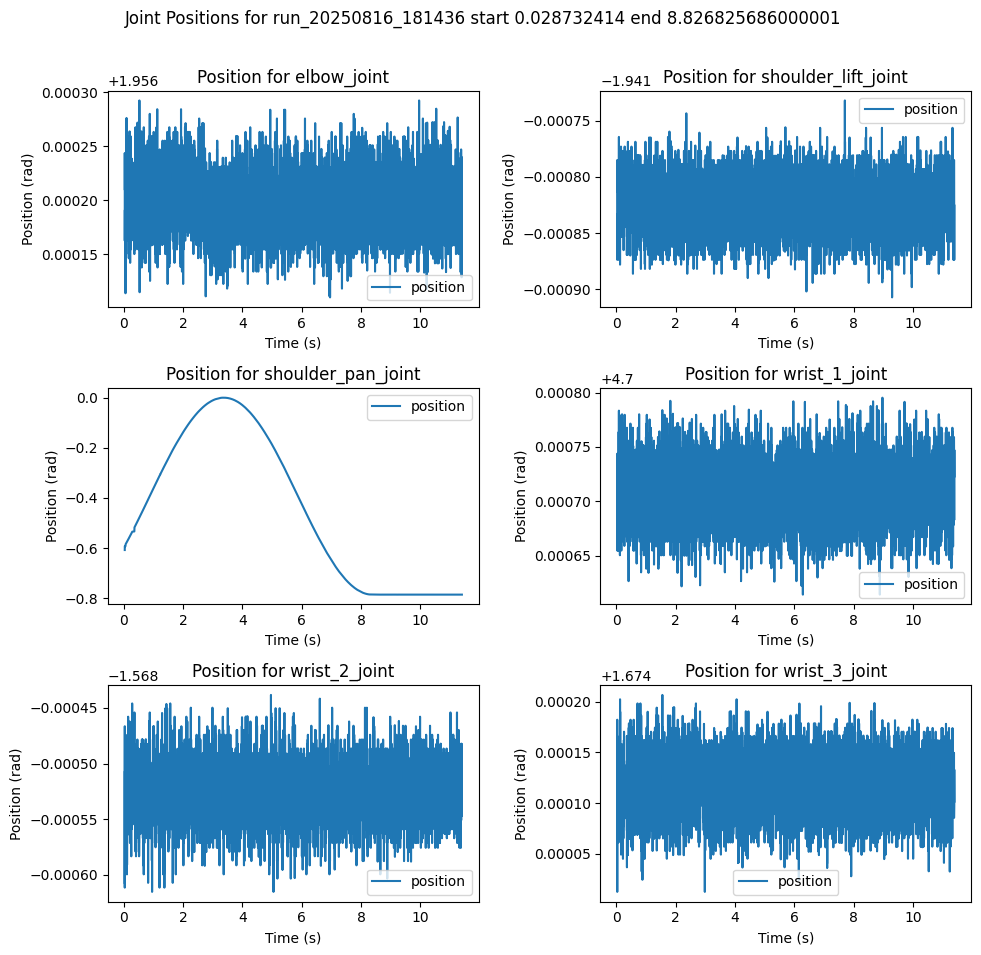

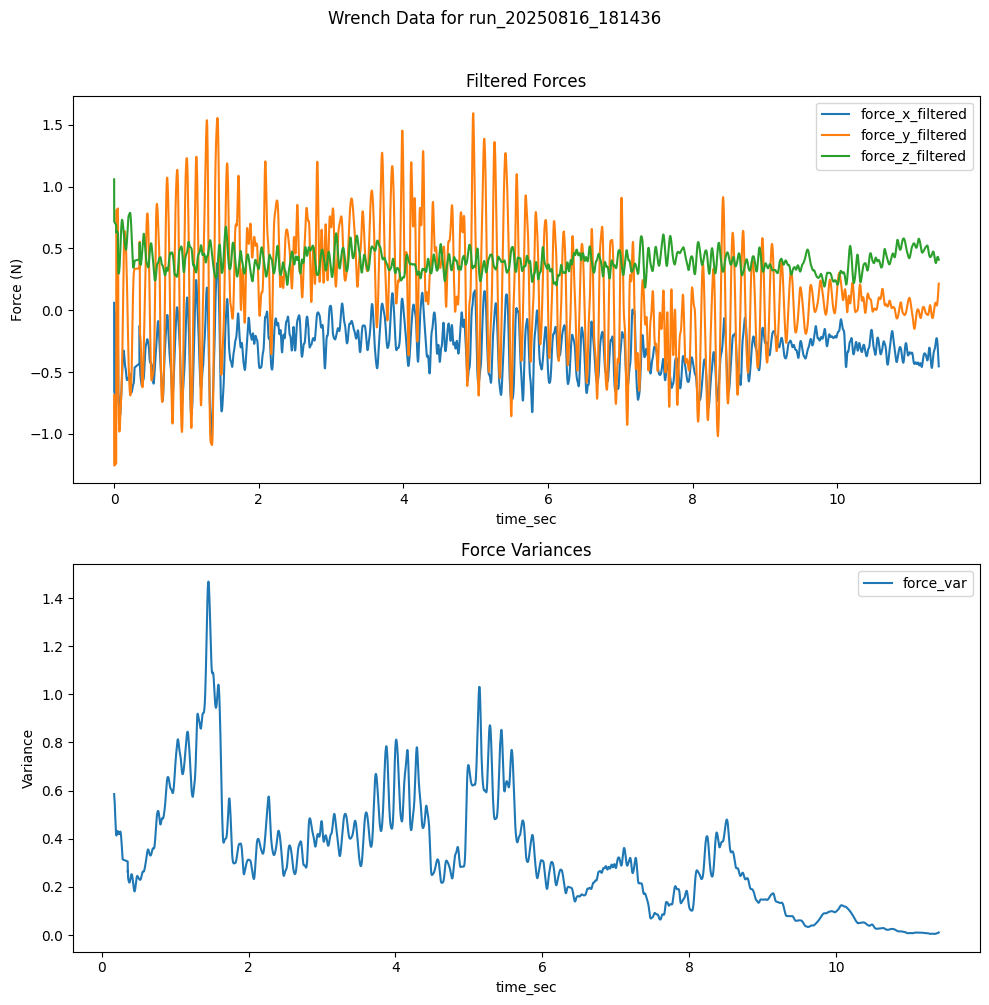

Processing run_20250816_181233...


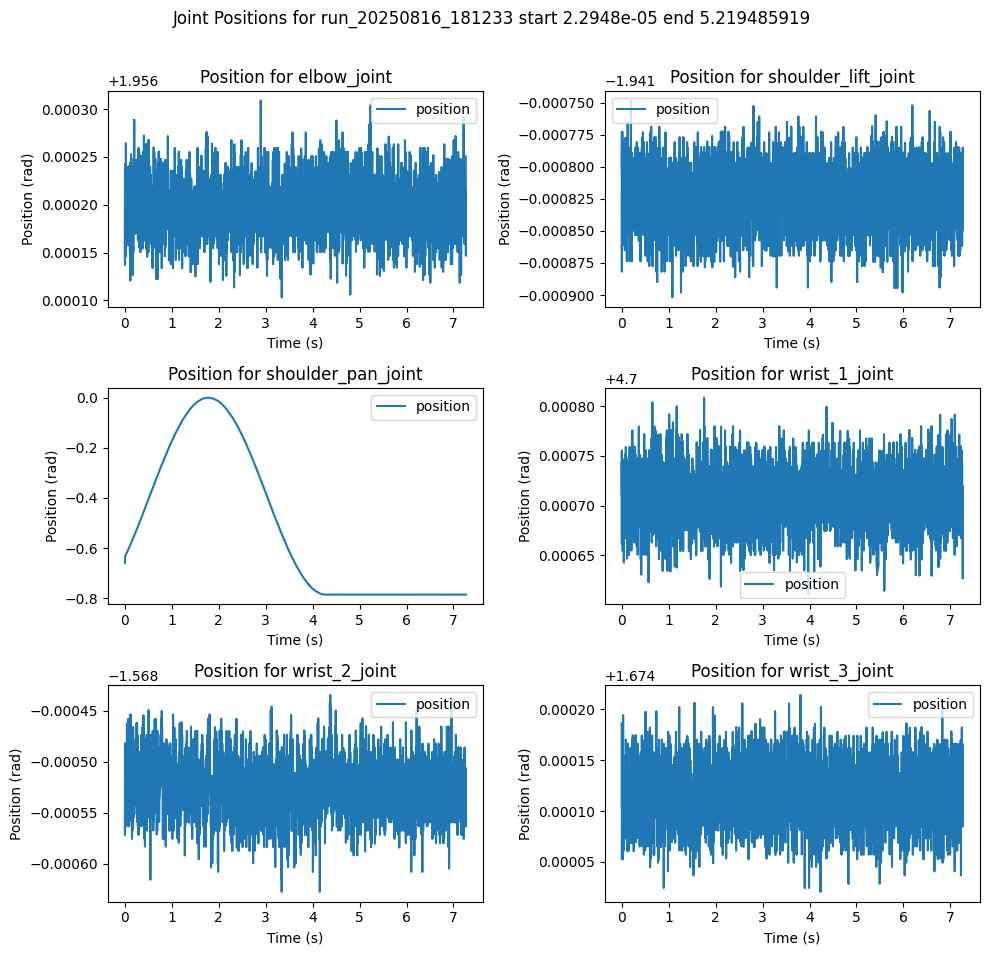

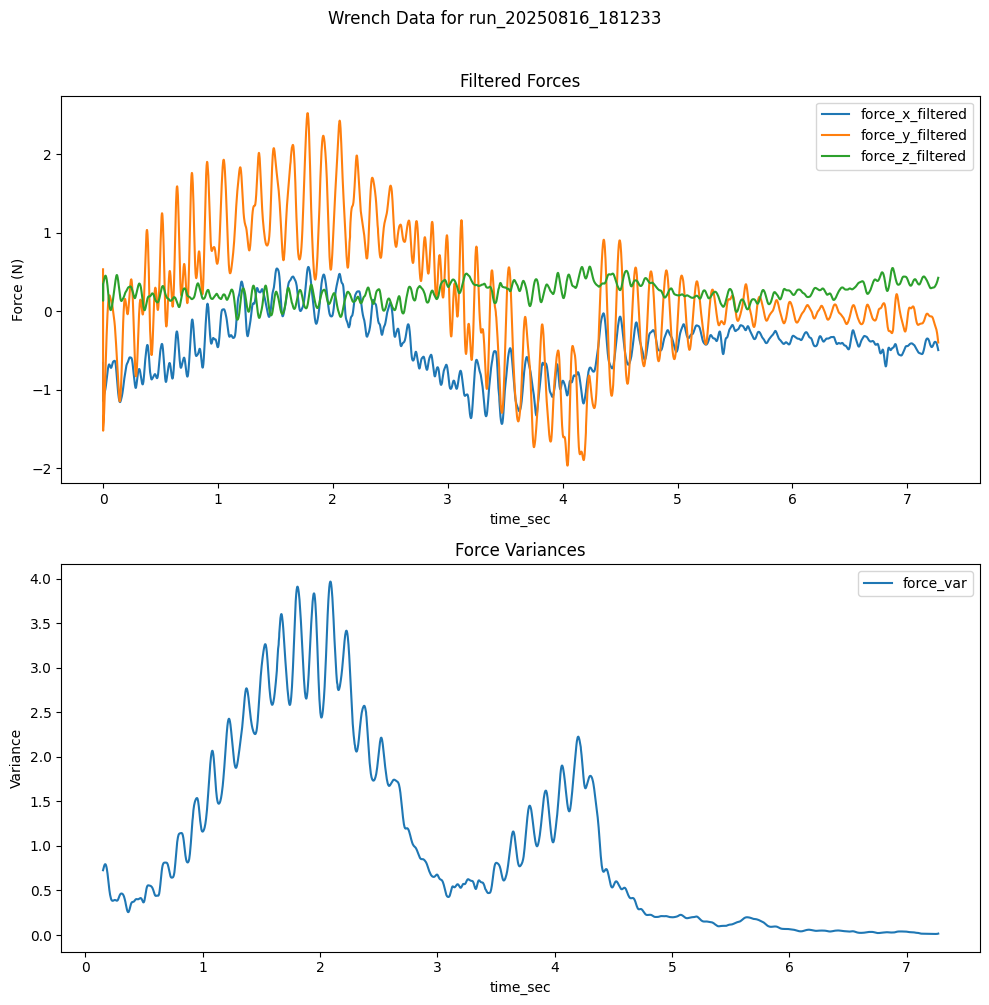

Processing run_20250816_181259...


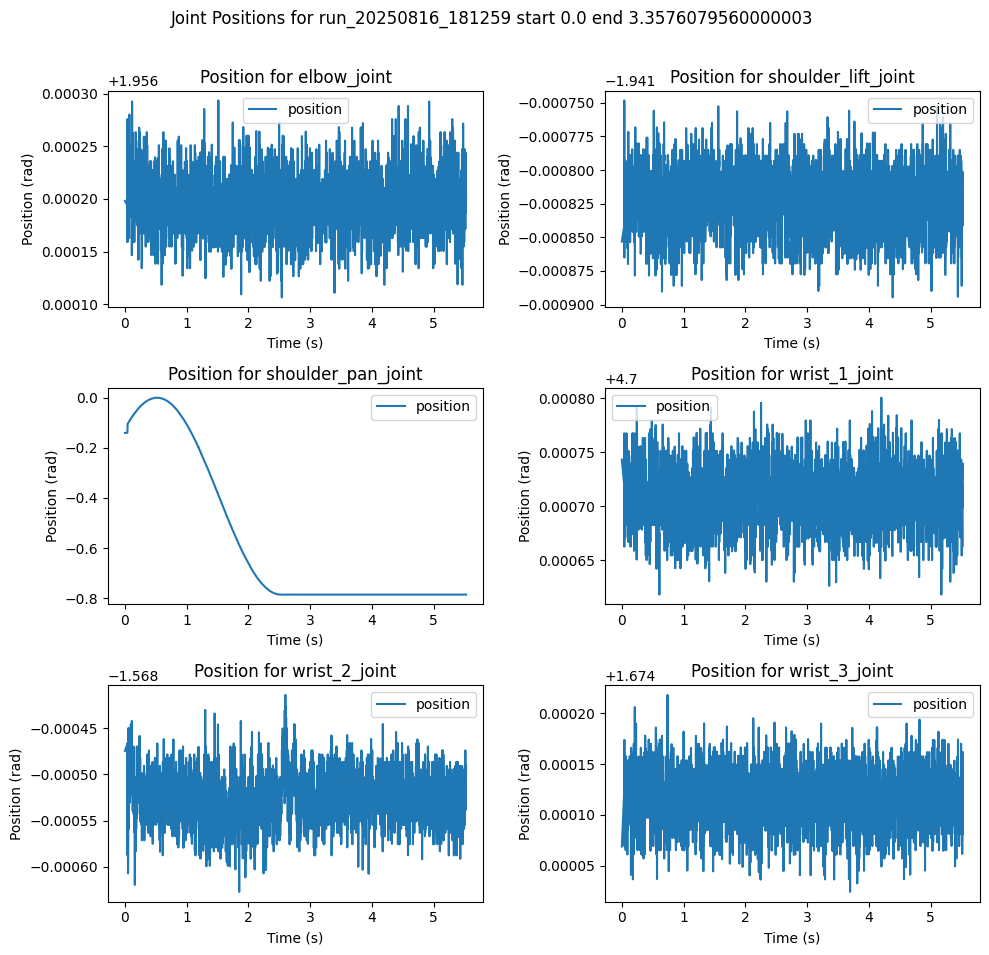

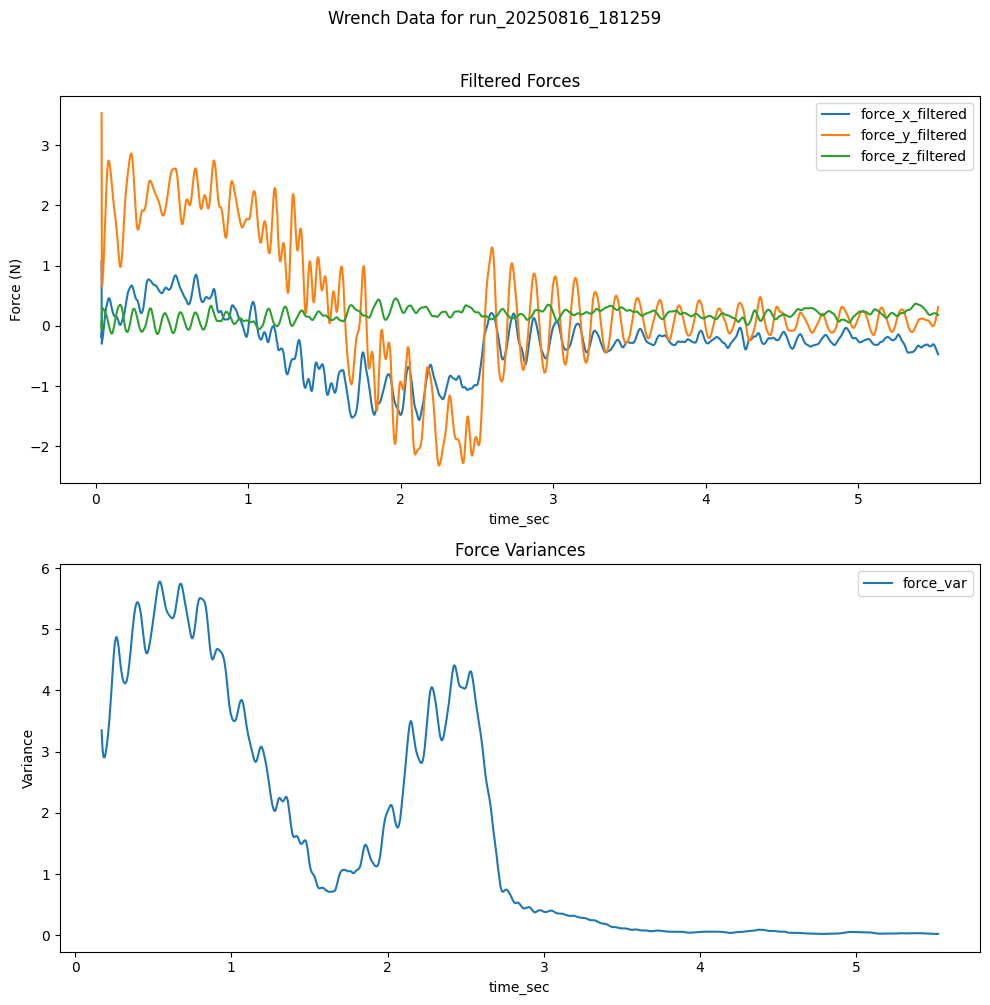

Processing run_20250816_181341...


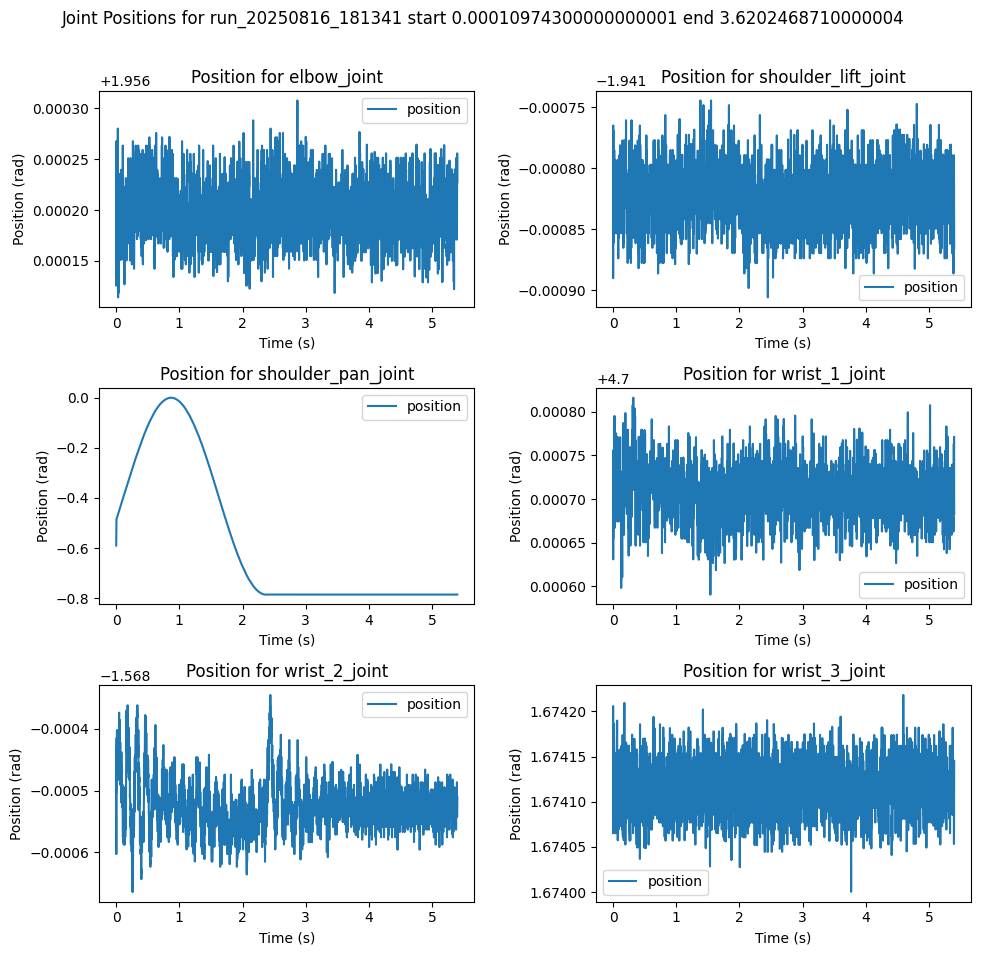

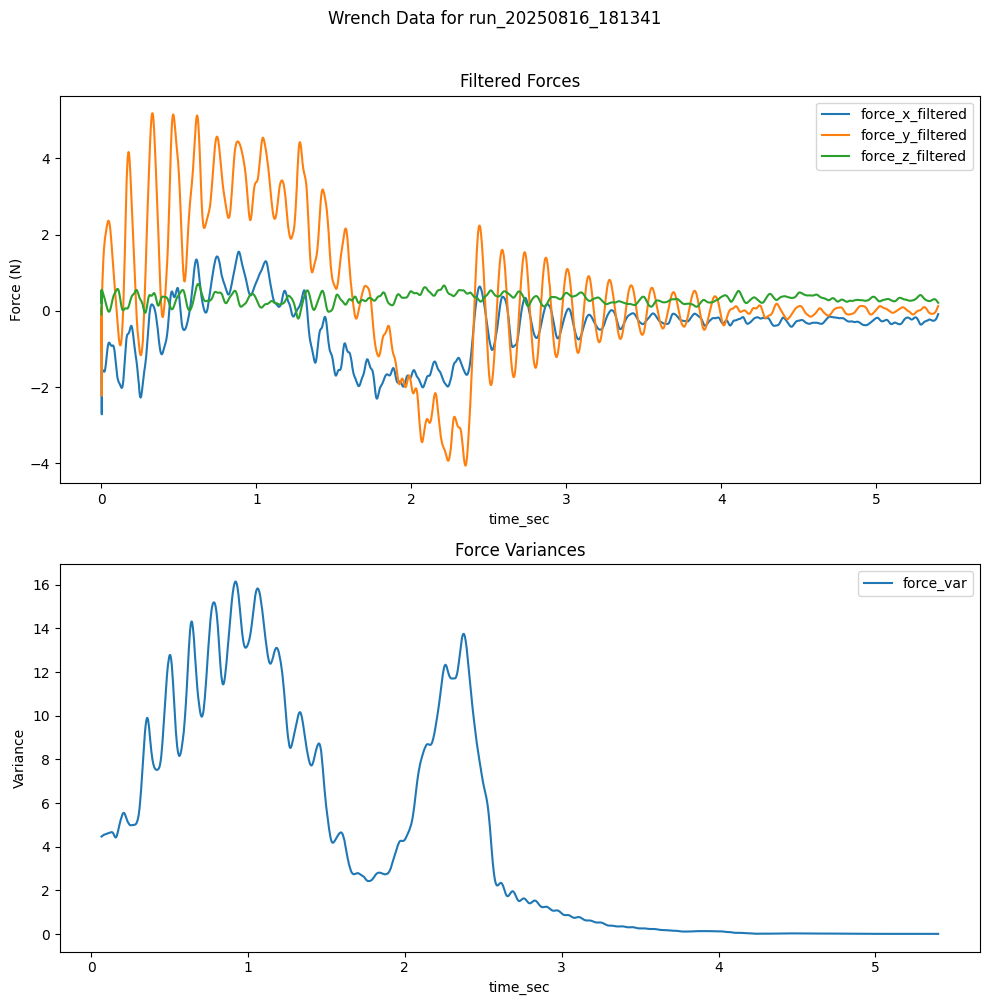

Processing run_20250816_181151...


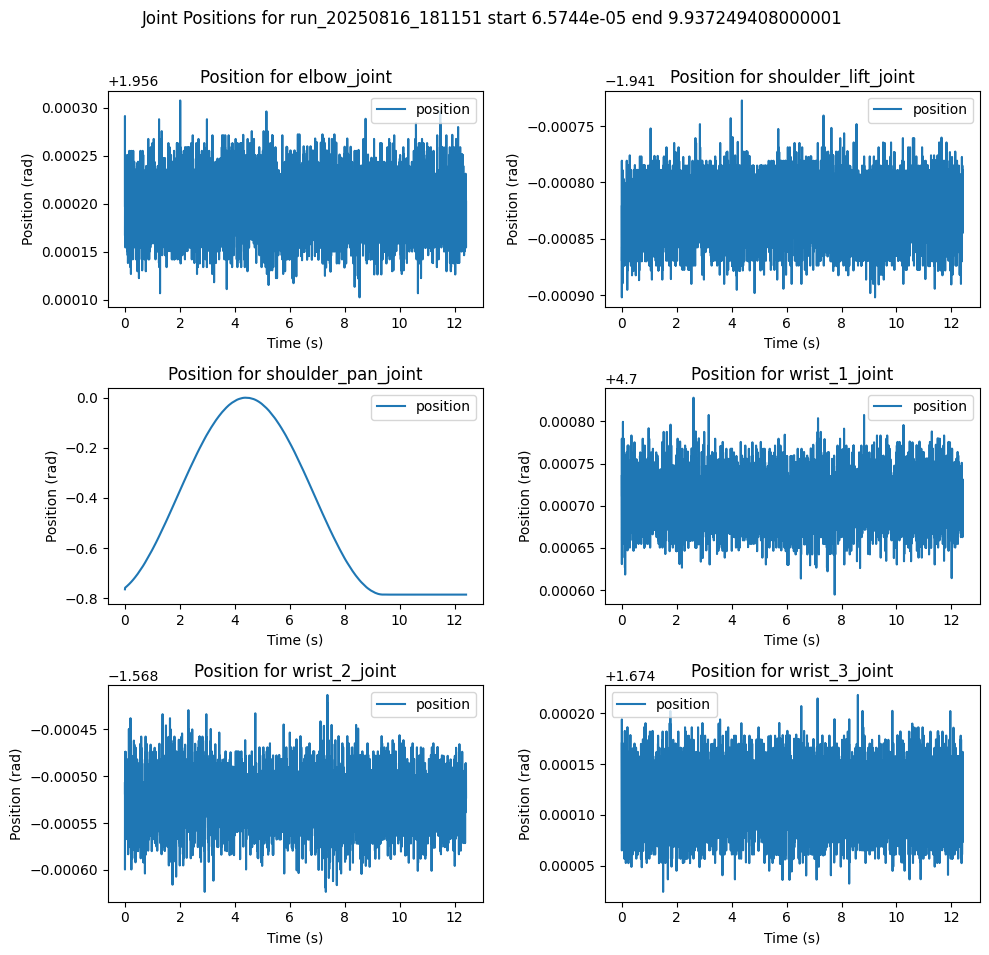

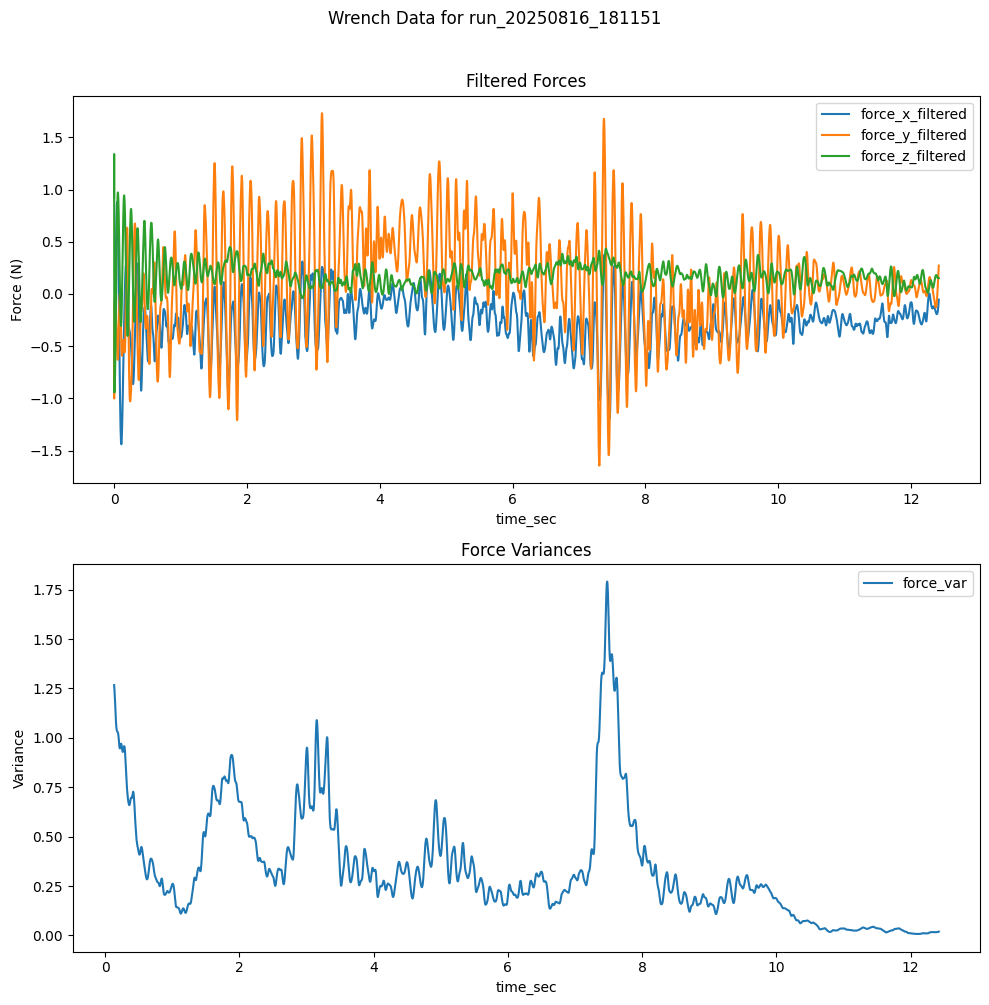

In [3]:
from utils import get_start_time, get_settling_time,read_rosbag,low_pass,add_variance

for bag_path in bag_dirs:
    df_js,df_wrench = read_rosbag(bag_path)
    # df_wrench = low_pass(df_wrench)
    # df_wrench = add_variance(df_wrench)

    print(f"Processing {bag_path.name}...")
    start, end = get_start_time(df_js), get_settling_time(df_wrench)
    # df_js, df_wrench = get_start_time(df_js), get_settling_time(df_wrench)
    if start is None or end is None:
        print(f"Skipping {bag_path.name} due to missing start or end time.")
        continue
    # import matplotlib.pyplot as plt
    # Add a scatter plot for the start point on each joint position plot
    # start_time = start['time_sec']
    # closest_index = df_js[df_js['joint_name'] == joint_name]['time_sec'].sub(start_time).abs().idxmin()
    # start_point = df_js.loc[closest_index]
    # ax.plot(start_point['time_sec'], start_point['position'], 'ro', label='Start Point')
    # ax.legend()
    # Plot joint positions in subplots within one figure
    num_joints = df_js['joint_name'].nunique()
    fig_joints, axes_joints = plt.subplots(3, 2, figsize=(10, 10))
    fig_joints.suptitle(f'Joint Positions for {bag_path.name} start {start.time_sec} end {end.time_sec} ')

    for i, joint_name in enumerate(df_js['joint_name'].unique()):
        ax = axes_joints[i // 2, i % 2]  # Distribute subplots in a 3x2 grid
        df_js[df_js['joint_name'] == joint_name].plot(x='time_sec', y='position', title=f'Position for {joint_name}', ax=ax)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Position (rad)')

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust layout to make room for the suptitle
    plt.show()

    # Plot wrench data in subplots within one figure
    fig_wrench, axes_wrench = plt.subplots(3, 1, figsize=(10, 15))
    fig_wrench.suptitle(f'Wrench Data for {bag_path.name}')

    # Plot filtered force and its variance for each axis
    df_wrench.plot(ax=axes_wrench[0], x='time_sec', y=['force_x_filtered', 'force_y_filtered', 'force_z_filtered'])
    axes_wrench[0].set_title('Filtered Forces')
    axes_wrench[0].set_ylabel('Force (N)')
    
    df_wrench.plot(ax=axes_wrench[1], x='time_sec', y=['force_var'])
    axes_wrench[1].set_title('Force Variances')
    axes_wrench[1].set_ylabel('Variance')

    # Hide the unused subplot
    axes_wrench[2].set_visible(False)

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust layout to make room for the suptitle
    plt.show()

    # print(f"Start time: {start['time_sec']:.4f}s, End time: {end['time_sec']:.4f}s")


In [6]:
df_wrench["time_sec"]

0        0.000010
1        0.000023
2        0.000040
3        0.000074
4        0.000086
          ...    
5732    11.375561
5733    11.377672
5734    11.379758
5735    11.381751
5736    11.383636
Name: time_sec, Length: 5737, dtype: float64

<Axes: title={'center': 'Joint Effort'}, xlabel='time_sec'>

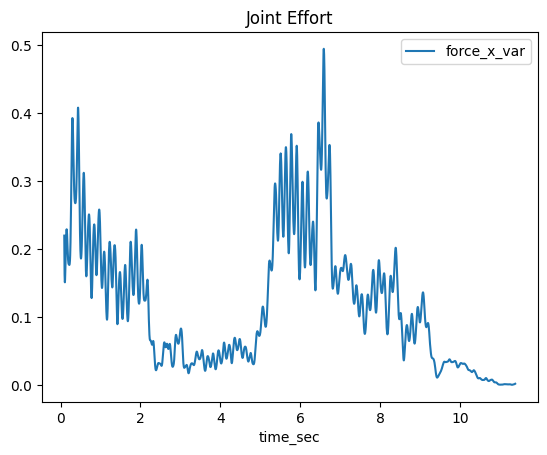

In [4]:
df_wrench.plot(x='time_sec', y='force_x_var', title='Joint Effort')

Now, let's read the content of one of these files. The `rosbags` library can handle the zstd decompression automatically.

In [10]:
if bag_dirs:
    bag_path = bag_dirs[-1]
    print(f"Reading topics from: {bag_path}")
    with Reader(bag_path) as reader:
        for connection in reader.connections:
            print(f"- Topic: {connection.topic} | Type: {connection.msgtype}")

Reading topics from: run_20250816_181151
- Topic: /force_torque_sensor_broadcaster/wrench | Type: geometry_msgs/msg/WrenchStamped
- Topic: /joint_states | Type: sensor_msgs/msg/JointState
- Topic: /speed_scaling_state_broadcaster/speed_scaling | Type: std_msgs/msg/Float64
- Topic: /tf | Type: tf2_msgs/msg/TFMessage
- Topic: /tf_static | Type: tf2_msgs/msg/TFMessage


In [91]:
import utils 
df_js, df_wrench = utils.read_rosbag(bag_path)
df_wrench = utils.apply_lowpass_filter(df_wrench, cutoff_hz=10, fs=250) 
settling_time = utils.get_last_settling_time(df_wrench, window=10, threshold=0.003)
settling_time

In [47]:
df = df_js
start_point = df[df['effort'].abs()>0.05].iloc[0]
start_point['time_sec']
df_wrench

timestamp    force_x   force_y   force_z  torque_x  torque_y  \
0     1755497922520498455  10.437710  7.348171 -5.392707 -0.286649 -0.253740   
1     1755497922565086671  10.234482  7.586454 -5.260706 -0.279446 -0.249891   
2     1755497922565298844  10.568202  7.349571 -5.387868 -0.284751 -0.258711   
3     1755497922565457172  10.377148  7.519706 -5.355537 -0.281490 -0.258025   
4     1755497922565605406  10.477990  7.472712 -5.455658 -0.284981 -0.261546   
...                   ...        ...       ...       ...       ...       ...   
3268  1755497929042617074   9.746394  7.215590 -5.685708 -0.299079 -0.293157   
3269  1755497929044566426   9.657752  7.088737 -5.454085 -0.307458 -0.292363   
3270  1755497929046641855   9.904804  7.483453 -5.491390 -0.301277 -0.297657   
3271  1755497929048497036  10.156009  7.384672 -5.496366 -0.304753 -0.301107   
3272  1755497929050530657   9.791747  7.506654 -5.400104 -0.304701 -0.301685   

      torque_z  time_sec  torque_x_filtered  torque_y_filtered  \
0    -0.013634  0.000000          -0.286638          -0.253732   
1    -0.019513  0.044588          -0.280274          -0.250917   
2    -0.028937  0.044800          -0.283486          -0.257021   
3    -0.025075  0.044959          -0.282680          -0.259906   
4    -0.018633  0.045107          -0.284285          -0.259928   
...        ...       ...                ...                ...   
3268 -0.022388  6.522119          -0.299577          -0.293162   
3269 -0.013412  6.524068          -0.306458          -0.292866   
3270 -0.022631  6.526143          -0.302364          -0.297097   
3271 -0.024253  6.527999          -0.304061          -0.301439   
3272 -0.028733  6.530032          -0.304707          -0.301693   

      torque_z_filtered  torque_x_var  torque_y_var  torque_z_var  
0             -0.013648           NaN           NaN           NaN  
1             -0.019835           NaN           NaN           NaN  
2             -0.028561           NaN           NaN           NaN  
3             -0.025145           NaN           NaN           NaN  
4             -0.019042           NaN           NaN           NaN  
...                 ...           ...           ...           ...  
3268          -0.019718      0.000039      0.000346      0.000009  
3269          -0.015972      0.000063      0.000333      0.000010  
3270          -0.020637      0.000077      0.000300      0.000011  
3271          -0.025336      0.000096      0.000309      0.000009  
3272          -0.028716      0.000113      0.000264      0.000014  

[3273 rows x 14 columns]

In [ ]:
y = "effort"
df["effort_diff"] = df.groupby('joint_name')[y].diff()
y = "effort_diff"

# start_point = df[(df['joint_name'] == 'shoulder_pan_joint') & (df['effort_diff_filtered'] > 0.05)].iloc[0]
# end_point = df[(df['joint_name'] == 'shoulder_pan_joint') & (df['effort_diff_filtered'] > 0.05)].iloc[-1]

y = "effort"
df[df['joint_name'] == 'shoulder_pan_joint'].plot(x='time_sec', y=y, title='Filtered Effort for Shoulder Pan Joint')

plt.plot(start_point['time_sec'], start_point[y], 'ro', label='Start Point')

df[df['joint_name'] == 'shoulder_pan_joint'].plot(x='time_sec', y="position", title='Filtered Effort for Shoulder Pan Joint')



Let's read the messages from a specific topic. For example, let's try to read from `/joint_states` if it exists.

<Axes: title={'center': 'Filtered Force X'}, xlabel='time_sec'>

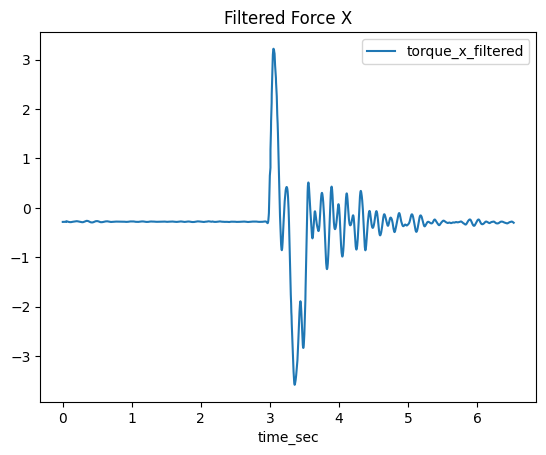

In [56]:
df_wrench.plot(x='time_sec', y='torque_x_filtered', title='Filtered Force X')

In [100]:
def get_settling_time(df_wrench):
    cutoff_freq = 10 # Hz
    filter_order = 2

    # Calculate the Nyquist frequency
    nyquist_freq = 0.5 * 250#sample_rate

    # Avoid division by zero if sample_rate is 0
    if nyquist_freq > 0:
        normal_cutoff = cutoff_freq / nyquist_freq

        # Design the Butterworth filter
        b, a = butter(filter_order, normal_cutoff, btype='low', analog=False)

        # Apply the filter to each force component using filtfilt for zero phase shift
        df_wrench['force_x_filtered'] = filtfilt(b, a, df_wrench['force_x'])
        df_wrench['force_y_filtered'] = filtfilt(b, a, df_wrench['force_y'])
        df_wrench['force_z_filtered'] = filtfilt(b, a, df_wrench['force_z'])

    FREQUENCY =500
    n_last = 3*FREQUENCY # Number of samples to consider for the last n seconds.
    window_size = 200  # The number of samples for the rolling variance window.
    variance_threshold = 1  # The variance value that indicates an unsettled state.

    df_wrench["force_x_var"] = df_wrench['force_x_filtered'].tail(n_last).rolling(window=window_size).var()
    df_wrench["force_y_var"] = df_wrench['force_y_filtered'].tail(n_last).rolling(window=window_size).var()
    df_wrench["force_z_var"] = df_wrench['force_z_filtered'].tail(n_last).rolling(window=window_size).var()


    unsettle_points = []
    for i,axis in enumerate(['x', 'y', 'z']):
        var_col = f'force_{axis}_var'
        # Get all points where variance is above the threshold.
        high_variance_indices = df_wrench.index[df_wrench[var_col] > variance_threshold]
        
        if not high_variance_indices.empty:
            # The last index in this series is the first point from the end to exceed the threshold.
            last_high_var_idx = high_variance_indices[-1]
            unsettle_points.append(df_wrench.loc[last_high_var_idx])
    latest_point = max(unsettle_points, key=lambda x: x['time_sec'])
    return latest_point

def get_start_time(df_js, threshold=0.05):
    """
    Get the first point where the effort exceeds a given threshold.
    """
    start_point = df_js[df_js['effort'].abs() > threshold].iloc[0]
    return start_point
start,end = get_start_time(df_js),get_settling_time(df_wrench)


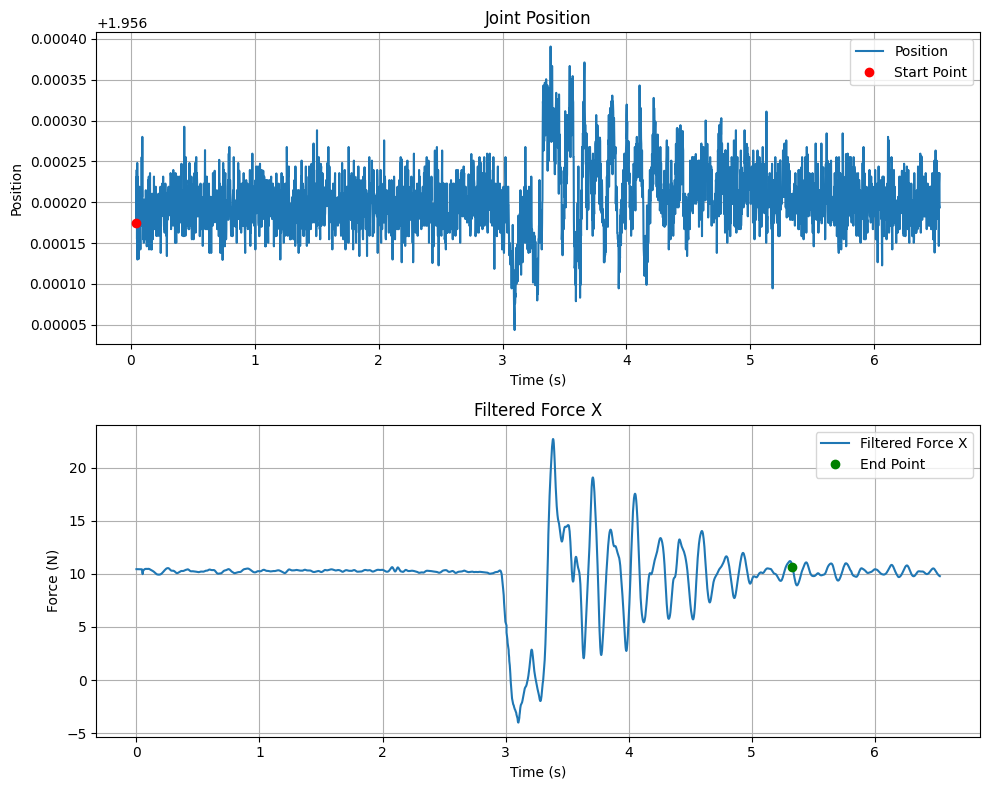

In [101]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot position data on the first subplot
axs[0].plot(df_js[df_js["joint_name"]=='elbow_joint'].time_sec, df_js[df_js["joint_name"]=='elbow_joint']['position'], label='Position')
axs[0].plot(start['time_sec'], start['position'], 'ro', label='Start Point')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Position')
axs[0].set_title('Joint Position')
axs[0].legend()
axs[0].grid(True)

# Plot force data on the second subplot
axs[1].plot(df_wrench['time_sec'], df_wrench['force_x_filtered'], label='Filtered Force X')
axs[1].plot(end['time_sec'], end['force_x_filtered'], 'go', label='End Point')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Force (N)')
axs[1].set_title('Filtered Force X')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


<Axes: title={'center': 'Force X Variance'}>

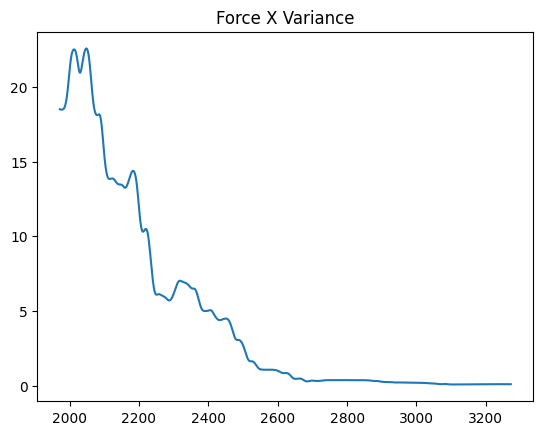

In [76]:
df_wrench["force_x_var"].plot(x='time_sec', title='Force X Variance')

Torque X: Unsettling event starts around time 5.1822s (variance > 1)
Torque Y: Unsettling event starts around time 5.3320s (variance > 1)
Torque Z: Unsettling event starts around time 5.1662s (variance > 1)


In [ ]:
if bag_dirs:
    bag_path = bag_dirs[0]
    with Reader(bag_path) as reader:
        # Create a list of connections to topics you are interested in
        connections = [c for c in reader.connections if c.topic == '/joint_states']
        if connections:
            print(f"Reading messages from '/joint_states' in {bag_path}\n")
            count = 0
            for connection, timestamp, rawdata in reader.messages(connections=connections):
                if count < 1: # Print first 5 messages
                    msg = deserialize_cdr(rawdata, connection.msgtype)
                    print(f"Time: {timestamp}\n{msg}\n")
                    count += 1
            if count == 0:
                print("No messages found on topic '/joint_states'.")
            
        else:
            print("Topic '/joint_states' not found in this bag file.")

Now we can plot the joint positions over time.

In [12]:
idx = -6
joint_states_data = []
if bag_dirs:
    bag_path = bag_dirs[idx]
    with Reader(bag_path) as reader:
        connections = [c for c in reader.connections if c.topic == '/joint_states']
        if connections:
            for connection, timestamp, rawdata in reader.messages(connections=connections):
                msg = deserialize_cdr(rawdata, connection.msgtype)
                for i, name in enumerate(msg.name):
                    joint_states_data.append({
                        'timestamp': timestamp,
                        'joint_name': name,
                        'position': msg.position[i],
                        'velocity': msg.velocity[i],
                        'effort': msg.effort[i]
                    })

if joint_states_data:
    df = pd.DataFrame(joint_states_data)
    # Convert nanosecond timestamp to seconds for plotting
    df['time_sec'] = (df['timestamp'] - df['timestamp'].min()) / 1e9
    print(f"Created a DataFrame with {len(df)} rows.")
    display(df.head())
else:
    print("No joint states data to process.")
    df = pd.DataFrame() # Create empty dataframe

wrench_data = []
if bag_dirs:
    bag_path = bag_dirs[idx]
    with Reader(bag_path) as reader:
        connections = [c for c in reader.connections if '/wrench' in c.topic]
        print(f"Found {len(connections)} connections for '/wrench' topics.")
        if connections:
            for connection, timestamp, rawdata in reader.messages(connections=connections):
                msg = deserialize_cdr(rawdata, connection.msgtype)
                wrench_data.append({
                    'timestamp': timestamp,
                    'force_x': msg.wrench.force.x,
                    'force_y': msg.wrench.force.y,
                    'force_z': msg.wrench.force.z,
                    'torque_x': msg.wrench.torque.x,
                    'torque_y': msg.wrench.torque.y,
                    'torque_z': msg.wrench.torque.z,
                })

if wrench_data:
    df_wrench = pd.DataFrame(wrench_data)
    df_wrench['time_sec'] = (df_wrench['timestamp'] - df_wrench['timestamp'].min()) / 1e9
    print(f"Created a wrench DataFrame with {len(df_wrench)} rows.")
    display(df_wrench.head())
else:
    print("No wrench data to process.")
    df_wrench = pd.DataFrame() # Create empty dataframe

Created a DataFrame with 19614 rows.


/var/folders/yj/4x4zwlx90yl63yyn00mwy_0h0000gn/T/ipykernel_57765/540387623.py:9: DeprecationWarning: Global serialization/deserialization functions have been replaced with
explicit typestores.

If you are deserializing messages from an AnyReader instance, simply
use its `.deserialize(data, typename)` method.

Otherwise instantiate a type store and use its methods:

from rosbags.typesys import Stores, get_typestore

typestore = get_typestore(Stores.ROS2_FOXY)
typestore.deserialize_cdr(data, typename)
  msg = deserialize_cdr(rawdata, connection.msgtype)


timestamp           joint_name  position  velocity    effort  \
0  1755497922565216291          elbow_joint  1.956174      -0.0 -4.119480   
1  1755497922565216291  shoulder_lift_joint -1.941773       0.0 -2.251686   
2  1755497922565216291   shoulder_pan_joint -0.785386       0.0 -0.260508   
3  1755497922565216291        wrist_1_joint  4.700699       0.0 -1.056999   
4  1755497922565216291        wrist_2_joint -1.568511       0.0 -0.159577   

   time_sec  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0

Found 1 connections for '/wrench' topics.
Created a wrench DataFrame with 3273 rows.


/var/folders/yj/4x4zwlx90yl63yyn00mwy_0h0000gn/T/ipykernel_57765/540387623.py:37: DeprecationWarning: Global serialization/deserialization functions have been replaced with
explicit typestores.

If you are deserializing messages from an AnyReader instance, simply
use its `.deserialize(data, typename)` method.

Otherwise instantiate a type store and use its methods:

from rosbags.typesys import Stores, get_typestore

typestore = get_typestore(Stores.ROS2_FOXY)
typestore.deserialize_cdr(data, typename)
  msg = deserialize_cdr(rawdata, connection.msgtype)


timestamp    force_x   force_y   force_z  torque_x  torque_y  \
0  1755497922520498455  10.437710  7.348171 -5.392707 -0.286649 -0.253740   
1  1755497922565086671  10.234482  7.586454 -5.260706 -0.279446 -0.249891   
2  1755497922565298844  10.568202  7.349571 -5.387868 -0.284751 -0.258711   
3  1755497922565457172  10.377148  7.519706 -5.355537 -0.281490 -0.258025   
4  1755497922565605406  10.477990  7.472712 -5.455658 -0.284981 -0.261546   

   torque_z  time_sec  
0 -0.013634  0.000000  
1 -0.019513  0.044588  
2 -0.028937  0.044800  
3 -0.025075  0.044959  
4 -0.018633  0.045107

Let's plot the force and torque components.

In [13]:
import numpy as np
import pandas as pd
import plotly.express as px

if not df_wrench.empty:
    # Ensure data is sorted by time for correct diff calculation
    df_wrench = df_wrench.sort_values('time_sec').reset_index(drop=True)

    # Calculate sampling rate
    N = len(df_wrench)
    if N > 1:
        # Use the mean difference for potentially non-uniformly sampled data
        T = df_wrench['time_sec'].diff().mean()
        sample_rate = 1.0 / T
        print(f"Number of samples: {N}, Estimated Sample Rate: {sample_rate:.2f} Hz")

        # Calculate FFT for each torque component
        yf_x = np.fft.fft(df_wrench['torque_x'].values)
        yf_y = np.fft.fft(df_wrench['torque_y'].values)
        yf_z = np.fft.fft(df_wrench['torque_z'].values)
        
        # Generate the frequency axis
        xf = np.fft.fftfreq(N, T)[:N//2]

        # Create a DataFrame for the FFT results
        df_fft = pd.DataFrame({
            'frequency': xf,
            'torque_x_amplitude': 2.0/N * np.abs(yf_x[0:N//2]),
            'torque_y_amplitude': 2.0/N * np.abs(yf_y[0:N//2]),
            'torque_z_amplitude': 2.0/N * np.abs(yf_z[0:N//2]),
        })

        # Plot the FFT amplitude spectrum
        fig_fft = px.line(
            df_fft,
            x='frequency', 
            y=['torque_x_amplitude', 'torque_y_amplitude', 'torque_z_amplitude'],
            title="FFT of Torque Components",
            labels={'frequency': 'Frequency (Hz)', 'value': 'Amplitude'}
        )
        fig_fft.show()
    else:
        print("Not enough data points to perform FFT.")
else:
    print("Wrench data frame is empty, cannot perform FFT.")

Number of samples: 3273, Estimated Sample Rate: 501.07 Hz


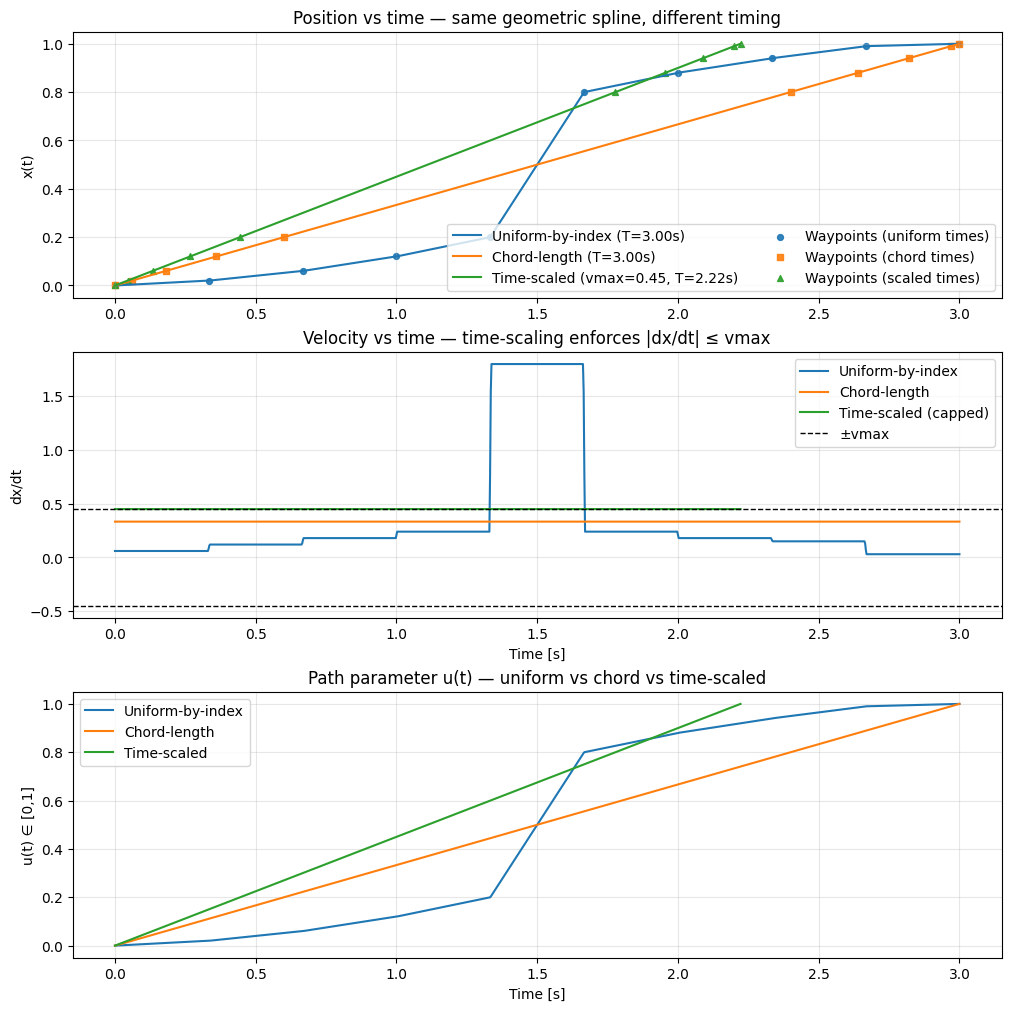

In [9]:
# 1D spline timing demo — SAME SHAPE, different timing:
#   (1) Uniform-by-index   (2) Chord-length   (3) Time-scaled with vmax
# pip install numpy scipy matplotlib

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# ------------------------------------------------------------
# Waypoints in 1D (add extra points near start & end to anchor)
# ------------------------------------------------------------
key_pts    = np.array([0.00, 0.20, 0.80, 1.00], dtype=float)
start_ex   = np.array([0.02, 0.06, 0.12])      # near start (not exactly equal)
end_ex     = np.array([0.88, 0.94, 0.99])      # near end (avoid exact duplicate)
P = np.unique(np.concatenate([start_ex, key_pts, end_ex]))
M = len(P)

# ------------------------------------------------------------
# Build ONE geometric cubic spline x(u) over u∈[0,1] (shape only)
# ------------------------------------------------------------
# Parameterize waypoints by cumulative chord (distance) → u_way in [0,1]
dists = np.abs(np.diff(P))
s = np.hstack([[0.0], np.cumsum(dists)])
u_way = s / (s[-1] if s[-1] > 0 else 1.0)

# Cubic interpolating spline (exact through waypoints). Shape is fixed!
x_of_u = make_interp_spline(u_way, P, k=3)

# High-res parameter grid for computations
U = np.linspace(0.0, 1.0, 1201)
X_geo = x_of_u(U)                # geometric path
dX_du = x_of_u.derivative(1)(U)  # needed for time scaling

# ------------------------------------------------------------
# Helper: build x(t) by mapping t -> u(t) then evaluating x(u(t))
# ------------------------------------------------------------
def x_and_v_from_u_of_t(u_of_t, t_grid):
    x = x_of_u(u_of_t)
    v = np.gradient(x, t_grid)  # dx/dt via finite diff (robust and clear)
    return x, v

# ------------------------------------------------------------
# (1) Uniform-by-index timing: equal time between waypoint *indices*
# ------------------------------------------------------------
T_total = 3.0  # desired total duration for (1) and (2) to compare apples-to-apples
t_way_uniform = np.linspace(0.0, T_total, M)  # equal time per waypoint index
# u(t): piecewise-linear mapping through (t_way_uniform -> u_way)
t_uniform = np.linspace(0.0, T_total, 1201)
u_uniform = np.interp(t_uniform, t_way_uniform, u_way)
x_uniform, v_uniform = x_and_v_from_u_of_t(u_uniform, t_uniform)

# ------------------------------------------------------------
# (2) Chord-length timing: time ∝ distance → longer segments take longer
# ------------------------------------------------------------
t_way_chord = (s / (s[-1] if s[-1] > 0 else 1.0)) * T_total  # chord-based timestamps
t_chord = np.linspace(0.0, T_total, 1201)
u_chord = np.interp(t_chord, t_way_chord, u_way)              # map times to same u
x_chord, v_chord = x_and_v_from_u_of_t(u_chord, t_chord)

# ------------------------------------------------------------
# (3) Time-scaling pass: enforce |dx/dt| ≤ vmax along SAME x(u)
# ------------------------------------------------------------
vmax = 0.45  # units/sec (tune this to see the effect)
eps = 1e-9
# dt/du = |dx/du| / vmax  ⇒ integrate over u to get t(u)
du = U[1] - U[0]
dt_du = np.abs(dX_du) / (vmax + eps)
t_of_u = np.zeros_like(U)
t_of_u[1:] = np.cumsum(0.5 * (dt_du[:-1] + dt_du[1:]) * du)  # trapezoid
T_scaled = float(t_of_u[-1])  # total time required given vmax

# Invert t(u) to u(t) on a uniform time grid
t_scaled = np.linspace(0.0, T_scaled, 1201)
u_scaled = np.interp(t_scaled, t_of_u, U)
x_scaled, v_scaled = x_and_v_from_u_of_t(u_scaled, t_scaled)

# Also compute the “times of waypoints” under each scheme (to mark them)
t_mark_uniform = np.interp(u_way, u_uniform, t_uniform)
t_mark_chord   = t_way_chord.copy()
t_mark_scaled  = np.interp(u_way, U, t_of_u)

# ------------------------------------------------------------
# PLOTS — clear, side-by-side comparisons
# ------------------------------------------------------------
fig, axes = plt.subplots(3, 1, figsize=(10, 10), constrained_layout=True)

# (A) Position vs time
ax = axes[0]
ax.plot(t_uniform, x_uniform, label=f"Uniform-by-index (T={T_total:.2f}s)")
ax.plot(t_chord,   x_chord,   label=f"Chord-length (T={T_total:.2f}s)")
ax.plot(t_scaled,  x_scaled,  label=f"Time-scaled (vmax={vmax:.2f}, T={T_scaled:.2f}s)")
# Mark waypoints (as dots) for each scheme
ax.scatter(t_mark_uniform, P, s=18, marker="o", alpha=0.9, label="Waypoints (uniform times)")
ax.scatter(t_mark_chord,   P, s=18, marker="s", alpha=0.9, label="Waypoints (chord times)")
ax.scatter(t_mark_scaled,  P, s=18, marker="^", alpha=0.9, label="Waypoints (scaled times)")
ax.set_title("Position vs time — same geometric spline, different timing")
ax.set_ylabel("x(t)")
ax.grid(alpha=0.3)
ax.legend(ncols=2)

# (B) Velocity vs time
ax = axes[1]
ax.plot(t_uniform, v_uniform, label="Uniform-by-index")
ax.plot(t_chord,   v_chord,   label="Chord-length")
ax.plot(t_scaled,  v_scaled,  label="Time-scaled (capped)")
ax.axhline(+vmax, linestyle="--", linewidth=1, color="k", label="±vmax")
ax.axhline(-vmax, linestyle="--", linewidth=1, color="k")
ax.set_title("Velocity vs time — time-scaling enforces |dx/dt| ≤ vmax")
ax.set_xlabel("Time [s]")
ax.set_ylabel("dx/dt")
ax.grid(alpha=0.3)
ax.legend()

# (C) u(t) — how fast we traverse the path parameter
ax = axes[2]
ax.plot(t_uniform, u_uniform, label="Uniform-by-index")
ax.plot(t_chord,   u_chord,   label="Chord-length")
ax.plot(t_scaled,  u_scaled,  label="Time-scaled")
ax.set_title("Path parameter u(t) — uniform vs chord vs time-scaled")
ax.set_xlabel("Time [s]")
ax.set_ylabel("u(t) ∈ [0,1]")
ax.grid(alpha=0.3)
ax.legend()

plt.show()

# -------------------
# What this shows
# -------------------
# • All three cases use the SAME x(u) (same shape), so differences are only timing/speed.
# • Uniform-by-index gives equal time per waypoint index — often too fast on short segments.
# • Chord-length allocates time by geometric distance — more natural speed.
# • Time-scaling computes t(u) from |dx/du| so that |dx/dt| ≤ vmax everywhere.
#   (Total time T_scaled grows automatically when vmax is small.)


In [4]:
# contextual_bo_min_demo.py
# Minimal, dependency-light demo:
# - Minimizes a synthetic contextual function f(x, c)
# - Each iteration: 2 "given" readings + 2 BO suggestions (EI for minimization)
# - Uses a lightweight GP (fixed hyperparams), NumPy + Pandas only
# - Saves CSV logs to ./contextual_bo_min_demo/

import math
import os
from pathlib import Path
import numpy as np
import pandas as pd

# -------------------------------
# Problem setup (edit as you like)
# -------------------------------
rng = np.random.default_rng(123)

# Decision variables: x in R^2 (bounds)
dim_x = 2
x_lows  = np.array([-2.0, -2.0])
x_highs = np.array([ 2.0,  2.0])

# Context vector: c in R^3 (changes each iteration)
dim_c = 3

# Synthetic objective to MINIMIZE: context-dependent minimizer x*(c)
def x_star_of_c(c):
    W = np.array([[ 0.9, -0.3,  0.2],
                  [-0.2,  0.6, -0.4]])
    b = np.array([0.3, -0.1])
    xs = np.tanh(W @ c + b)          # in [-1, 1]^2
    return x_lows + (xs + 1)/2 * (x_highs - x_lows)

def A_of_c(c):
    s = 0.7 + 0.6 * (1 + np.tanh(np.array([c[0], c[2]])))  # > 0
    return np.diag(s)

def f_true(x, c):
    xs = x_star_of_c(c)
    A  = A_of_c(c)
    quad = (x - xs) @ (A @ (x - xs))              # bowl around x*
    inter = 0.25*np.sin(1.7*x[0] + 0.3*c[1]) + 0.15*np.cos(1.3*x[1] - 0.5*c[0])
    return quad + inter

noise_std = 0.03  # observation noise

# ------------------------------------------
# Lightweight GP (fixed hyperparams, ARD RBF)
# ------------------------------------------
def fit_gp(Z, y):
    """
    Z: [N, Dtot] inputs with Dtot = dim_x + dim_c
    y: [N, 1] targets in real scale (no standardization required by caller)
    Returns: predict(Ztest) -> (mu, var) in real scale
    """
    Z_mean = Z.mean(axis=0, keepdims=True)
    Z_std  = Z.std(axis=0, keepdims=True) + 1e-9
    Zn = (Z - Z_mean) / Z_std

    y_mean = y.mean()
    y_std  = y.std() + 1e-9
    yn = (y - y_mean) / y_std

    sig_var   = 1.0           # y standardized
    noise_var = 0.05**2
    ell = np.full(Zn.shape[1], 0.8, dtype=float)  # ARD lengthscales

    def ard_rbf(a, b):
        aa = a / ell
        bb = b / ell
        a2 = np.sum(aa*aa, axis=1, keepdims=True)        # [N,1]
        b2 = np.sum(bb*bb, axis=1, keepdims=True).T      # [1,M]
        dist2 = a2 + b2 - 2.0 * (aa @ bb.T)              # [N,M]
        return sig_var * np.exp(-0.5 * dist2)

    K = ard_rbf(Zn, Zn) + noise_var * np.eye(Zn.shape[0])
    L = np.linalg.cholesky(K + 1e-6 * np.eye(K.shape[0]))
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, yn))

    def predict(Ztest):
        Ztest_n = (Ztest - Z_mean) / Z_std
        K_s = ard_rbf(Zn, Ztest_n)                    # [N,T]
        mu = K_s.T @ alpha                            # [T,1] standardized
        v  = np.linalg.solve(L, K_s)                  # [N,T]
        k_ss = sig_var * np.ones(Ztest_n.shape[0])    # RBF: k(x,x) = sig_var
        var = k_ss - np.sum(v*v, axis=0)              # [T]
        var = np.clip(var, 1e-9, None).reshape(-1, 1)
        # de-standardize
        mu_real  = mu * y_std + y_mean
        var_real = var * (y_std**2)
        return mu_real, var_real

    return predict

# ------------------------------------
# Expected Improvement (MINIMIZATION)
# ------------------------------------
def normal_cdf(x):
    # x can be ndarray
    return 0.5 * (1.0 + np.vectorize(math.erf)(x / np.sqrt(2.0)))

def normal_pdf(x):
    return (1.0 / np.sqrt(2.0 * np.pi)) * np.exp(-0.5 * x * x)

def expected_improvement_min(mu, var, best_f, xi=0.0):
    """
    EI for MINIMIZATION.
    mu, var: [T,1] in real scale
    best_f: scalar, current best (lowest) observed y
    """
    sigma = np.sqrt(var)
    imp   = best_f - mu - xi
    Z     = np.divide(imp, sigma, out=np.zeros_like(imp), where=(sigma > 0))
    ei    = imp * normal_cdf(Z) + sigma * normal_pdf(Z)
    ei    = np.where(sigma <= 0, 0.0, ei)
    return ei

# ----------------------------------------------------
# Acquisition optimization over x, conditioned on c_t
# ----------------------------------------------------
def propose_x_given_c(predict_fn, c_t, q=2, n_rand=4000, xi=0.01):
    # random search over x-box; pick top-q EI
    xr = rng.random((n_rand, dim_x)) * (x_highs - x_lows) + x_lows
    c_rep = np.repeat(c_t.reshape(1, -1), n_rand, axis=0)
    Ztest = np.hstack([xr, c_rep])
    mu, var = predict_fn(Ztest)
    ei = expected_improvement_min(mu, var, best_f=propose_x_given_c.best_f, xi=xi).reshape(-1)
    top = np.argsort(-ei)[:q]
    return xr[top], ei[top], mu[top].reshape(-1), var[top].reshape(-1)
propose_x_given_c.best_f = np.inf  # will be updated each iter

# ---------------------
# Simulation parameters
# ---------------------
T        = 25  # iterations
q_given  = 2   # given readings per iter
q_bo     = 2   # BO suggestions per iter
seed_N   = 6   # initial seed evaluations

# ---------------
# Initialization
# ---------------
eval_rows = []  # (iter, kind, x1, x2, c1, c2, c3, y)

# Seed data: random contexts and x
Xs = rng.random((seed_N, dim_x)) * (x_highs - x_lows) + x_lows
Cs = rng.normal(0.0, 1.0, size=(seed_N, dim_c))
Ys = []
for i in range(seed_N):
    y_obs = f_true(Xs[i], Cs[i]) + rng.normal(0, noise_std)
    Ys.append(y_obs)
    eval_rows.append((0, "seed", Xs[i,0], Xs[i,1], Cs[i,0], Cs[i,1], Cs[i,2], y_obs))
Ys = np.array(Ys).reshape(-1, 1)
Z  = np.hstack([Xs, Cs])
incumbent_y = float(Ys.min())
incumbent_ix = int(np.argmin(Ys))
incumbent_xc = (Xs[incumbent_ix].copy(), Cs[incumbent_ix].copy())
propose_x_given_c.best_f = incumbent_y

# -----------
# Main loop
# -----------
for t in range(1, T+1):
    # Simulate a new context c_t (3 drifting modes)
    mode = rng.integers(0, 3)
    centers = np.array([[ 0.5, -0.3,  0.6],
                        [-0.8,  0.2, -0.4],
                        [ 0.2,  0.7,  0.1]])
    c_t = centers[mode] + rng.normal(0, 0.2, size=(dim_c,))

    # Fit GP on all data so far
    predict_fn = fit_gp(Z, Ys)

    # Two given readings: near incumbent 60% of the time, else random
    if rng.random() < 0.6:
        x_base  = incumbent_xc[0]
        X_given = x_base + rng.normal(0, 0.2, size=(q_given, dim_x))
    else:
        X_given = rng.random((q_given, dim_x)) * (x_highs - x_lows) + x_lows
    X_given = np.clip(X_given, x_lows, x_highs)

    # Two BO suggestions conditioned on c_t
    X_bo, ei_vals, mu_vals, var_vals = propose_x_given_c(predict_fn, c_t, q=q_bo, n_rand=4000, xi=0.01)

    # Evaluate all four under c_t
    X_batch = np.vstack([X_given, X_bo])
    Y_batch = []
    for i, x in enumerate(X_batch):
        y_obs = f_true(x, c_t) + rng.normal(0, noise_std)
        Y_batch.append(y_obs)
        kind = "given" if i < q_given else "bo"
        eval_rows.append((t, kind, x[0], x[1], c_t[0], c_t[1], c_t[2], y_obs))
    Y_batch = np.array(Y_batch).reshape(-1, 1)

    # Update dataset and incumbent
    C_block = np.repeat(c_t.reshape(1, -1), X_batch.shape[0], axis=0)
    Z  = np.vstack([Z,  np.hstack([X_batch, C_block])])
    Ys = np.vstack([Ys, Y_batch])

    if Y_batch.min() < incumbent_y:
        incumbent_y = float(Y_batch.min())
        incumbent_xc = (X_batch[int(np.argmin(Y_batch))].copy(), c_t.copy())
    propose_x_given_c.best_f = incumbent_y

# ----------
# Save logs
# ----------
out_dir = Path("./contextual_bo_min_demo")
os.makedirs(out_dir, exist_ok=True)

df_log = pd.DataFrame(eval_rows, columns=["iter","kind","x1","x2","c1","c2","c3","y"])
df_log.to_csv(out_dir / "eval_log.csv", index=False)

# Best-so-far per iteration (simple convergence view)
best_so_far = []
cur_best = np.inf
for t, grp in df_log.groupby("iter"):
    cur_best = min(cur_best, grp["y"].min())
    best_so_far.append((t, cur_best))
df_regret = pd.DataFrame(best_so_far, columns=["iter","best_y_so_far"])
df_regret["simple_regret_vs_oracle"] = df_regret["best_y_so_far"] - df_log["y"].min()
df_regret.to_csv(out_dir / "regret.csv", index=False)

# Print short summary
print("=== Contextual BO (minimization) ===")
print(f"Iterations: {T}, given/iter: {q_given}, bo/iter: {q_bo}")
print(f"Oracle best y (over all evals): {df_log['y'].min():.4f}")
print(f"Final best y so far: {df_regret['best_y_so_far'].iloc[-1]:.4f}")
print(f"Logs saved to: {out_dir.resolve()}")


=== Contextual BO (minimization) ===
Iterations: 25, given/iter: 2, bo/iter: 2
Oracle best y (over all evals): -0.1147
Final best y so far: -0.1147
Logs saved to: /Users/test/Coding/ur_ws/sdu_ur_a/colcon_ws/data/contextual_bo_min_demo


In [7]:
# Re-running after kernel reset: Step-by-step visualization of EI in 1D

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


# 1D objective
rng = np.random.default_rng(7)
x_low, x_high = -3.0, 3.0

def f_true_noiseless(x):
    return (x - 1.2)**2 + 0.2*np.sin(3.0*x) + 0.05*np.cos(5.0*x)

noise_std = 0.05
def f_obs(x):
    return f_true_noiseless(x) + rng.normal(0, noise_std, size=x.shape)

# Lightweight GP
def fit_gp_1d(X, y):
    Z = X
    Z_mean = Z.mean(axis=0, keepdims=True)
    Z_std  = Z.std(axis=0, keepdims=True) + 1e-9
    Zn = (Z - Z_mean) / Z_std

    y_mean = y.mean()
    y_std  = y.std() + 1e-9
    yn = (y - y_mean) / y_std

    sig_var   = 1.0
    noise_var = 0.05**2
    ell = np.array([0.6])

    def ard_rbf(a, b):
        aa = a / ell
        bb = b / ell
        a2 = np.sum(aa*aa, axis=1, keepdims=True)
        b2 = np.sum(bb*bb, axis=1, keepdims=True).T
        dist2 = a2 + b2 - 2.0 * (aa @ bb.T)
        return sig_var * np.exp(-0.5 * dist2)

    K = ard_rbf(Zn, Zn) + noise_var * np.eye(Zn.shape[0])
    L = np.linalg.cholesky(K + 1e-6 * np.eye(K.shape[0]))
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, yn))

    def predict(Xtest):
        Ztest = Xtest
        Ztest_n = (Ztest - Z_mean) / Z_std
        K_s = ard_rbf(Zn, Ztest_n)
        mu = K_s.T @ alpha
        v  = np.linalg.solve(L, K_s)
        k_ss = sig_var * np.ones(Ztest_n.shape[0])
        var = k_ss - np.sum(v*v, axis=0)
        var = np.clip(var, 1e-9, None).reshape(-1,1)
        mu_real  = mu * y_std + y_mean
        var_real = var * (y_std**2)
        return mu_real, var_real

    return predict

# EI for minimization
def normal_cdf(x):
    return 0.5 * (1.0 + np.vectorize(math.erf)(x / np.sqrt(2.0)))

def normal_pdf(x):
    return (1.0 / np.sqrt(2.0 * np.pi)) * np.exp(-0.5 * x * x)

def expected_improvement_min(mu, var, best_f, xi=0.01):
    sigma = np.sqrt(var)
    imp   = best_f - mu - xi
    Z     = np.divide(imp, sigma, out=np.zeros_like(imp), where=(sigma > 0))
    ei    = imp * normal_cdf(Z) + sigma * normal_pdf(Z)
    ei    = np.where(sigma <= 0, 0.0, ei)
    return ei

# BO loop with visualization
out_dir = Path("data/ei_1d_walkthrough")
out_dir.mkdir(parents=True, exist_ok=True)

X = np.array([[-2.5], [0.0], [2.25]], dtype=float)
y = f_obs(X.flatten()).reshape(-1,1)

xx = np.linspace(x_low, x_high, 600).reshape(-1,1)
f_noiseless = f_true_noiseless(xx.flatten()).reshape(-1,1)

selected = []
iters = 6
for t in range(1, iters+1):
    predict = fit_gp_1d(X, y)
    mu, var = predict(xx)
    best_f = y.min().item()
    ei = expected_improvement_min(mu, var, best_f, xi=0.01)

    x_next = xx[np.argmax(ei)].reshape(1,1)
    y_next = f_obs(x_next.flatten()).reshape(1,1)
    selected.append((t, float(x_next[0,0]), float(y_next[0,0])))

    # Figure 1
    plt.figure()
    plt.plot(xx, f_noiseless)
    plt.scatter(X, y, s=25)
    plt.scatter(x_next, y_next, s=40, marker='x')
    plt.xlabel("x"); plt.ylabel("f(x) (true + observed)")
    plt.title(f"Iteration {t}: True function and observations")
    plt.tight_layout()
    plt.savefig(out_dir / f"iter_{t:02d}_true_and_points.png")
    plt.close()

    # Figure 2
    plt.figure()
    plt.plot(xx, mu)
    plt.fill_between(xx.flatten(), (mu-2*np.sqrt(var)).flatten(),
                     (mu+2*np.sqrt(var)).flatten(), alpha=0.2)
    plt.scatter(X, y, s=25)
    plt.scatter(x_next, y_next, s=40, marker='x')
    plt.xlabel("x"); plt.ylabel("Predicted mean ± 2σ")
    plt.title(f"Iteration {t}: GP surrogate")
    plt.tight_layout()
    plt.savefig(out_dir / f"iter_{t:02d}_gp_mean_uncertainty.png")
    plt.close()

    # Figure 3
    plt.figure()
    plt.plot(xx, ei)
    plt.scatter(x_next, np.max(ei), s=40, marker='x')
    plt.xlabel("x"); plt.ylabel("EI (min)")
    plt.title(f"Iteration {t}: Expected Improvement")
    plt.tight_layout()
    plt.savefig(out_dir / f"iter_{t:02d}_ei.png")
    plt.close()

    # Update dataset
    X = np.vstack([X, x_next])
    y = np.vstack([y, y_next])

df_sel = pd.DataFrame(selected, columns=["iter","x_next","y_observed"])

files = sorted([p.as_posix() for p in out_dir.glob("*.png")])
(len(files), files[:6])


(18,
 ['data/ei_1d_walkthrough/iter_01_ei.png',
  'data/ei_1d_walkthrough/iter_01_gp_mean_uncertainty.png',
  'data/ei_1d_walkthrough/iter_01_true_and_points.png',
  'data/ei_1d_walkthrough/iter_02_ei.png',
  'data/ei_1d_walkthrough/iter_02_gp_mean_uncertainty.png',
  'data/ei_1d_walkthrough/iter_02_true_and_points.png'])

In [18]:
from scipy.signal import butter, filtfilt
import plotly.express as px

# This code assumes 'df_wrench' DataFrame and 'sample_rate' variable exist from previous steps.
if not df_wrench.empty and 'sample_rate' in locals() and len(df_wrench) > 1:
    # Filter parameters
    cutoff_freq = 100 # Hz
    filter_order = 2
    
    # Calculate the Nyquist frequency
    nyquist_freq = 0.5 * 250#sample_rate
    
    # Avoid division by zero if sample_rate is 0
    if nyquist_freq > 0:
        normal_cutoff = cutoff_freq / nyquist_freq

        # Design the Butterworth filter
        b, a = butter(filter_order, normal_cutoff, btype='low', analog=False)

        # Apply the filter to each torque component using filtfilt for zero phase shift
        df_wrench['torque_x_filtered'] = filtfilt(b, a, df_wrench['torque_x'])
        df_wrench['torque_y_filtered'] = filtfilt(b, a, df_wrench['torque_y'])
        df_wrench['torque_z_filtered'] = filtfilt(b, a, df_wrench['torque_z'])

        print("Successfully applied a 15 Hz low-pass filter to torque signals.")

        # Plot original vs. filtered data for comparison
        fig_filter_comp = px.line(
            df_wrench,
            x='time_sec',
        y=['torque_x_filtered'],# 'torque_y', 'torque_y_filtered', 'torque_z', 'torque_z_filtered'],
            title="Original vs. Low-Pass Filtered Torque (15 Hz Cutoff)",
            labels={'time_sec': 'Time (s)', 'value': 'Torque (Nm)'}
        )
        fig_filter_comp.show()

Successfully applied a 15 Hz low-pass filter to torque signals.


In [19]:
# Ensure df_wrench exists and has enough data
if not df_wrench.empty and len(df_wrench) >= 50:
    # Define the number of last elements to consider for settling
    n_last = 50

    # Calculate the mean of the last n_last elements for each torque component
    torque_x_mean = df_wrench['torque_x'].tail(n_last).mean()
    torque_y_mean = df_wrench['torque_y'].tail(n_last).mean()
    torque_z_mean = df_wrench['torque_z'].tail(n_last).mean()

    # Define the window size for the moving box variance calculation
    window_size = 10  # Adjust as needed

    # Calculate the moving box variance around the mean for each torque component
    torque_x_variance = df_wrench['torque_x'].tail(n_last).rolling(window=window_size).var()
    torque_y_variance = df_wrench['torque_y'].tail(n_last).rolling(window=window_size).var()
    torque_z_variance = df_wrench['torque_z'].tail(n_last).rolling(window=window_size).var()

    # Define a threshold for the variance to determine settling
    variance_threshold = 0.001  # Adjust as needed

    # Check if the variance is below the threshold for all torque components
    settled_x = (torque_x_variance.iloc[-1] if pd.notna(torque_x_variance.iloc[-1]) else 0) > variance_threshold
    settled_y = (torque_y_variance.iloc[-1] if pd.notna(torque_y_variance.iloc[-1]) else 0) > variance_threshold
    settled_z = (torque_z_variance.iloc[-1] if pd.notna(torque_z_variance.iloc[-1]) else 0) > variance_threshold

    # Print the results
    print(f"Torque X Mean: {torque_x_mean:.4f}, Variance: {torque_x_variance.iloc[-1]:.6f}, Settled: {settled_x}")
    print(f"Torque Y Mean: {torque_y_mean:.4f}, Variance: {torque_y_variance.iloc[-1]:.6f}, Settled: {settled_y}")
    print(f"Torque Z Mean: {torque_z_mean:.4f}, Variance: {torque_z_variance.iloc[-1]:.6f}, Settled: {settled_z}")



    # Add scatter plots to indicate settling points
    if settled_x:
        fig_filter_comp.add_scatter(x=[df_wrench['time_sec'].iloc[-1]], y=[torque_x_mean],
                        mode='markers', marker=dict(color='green', size=10),
                        name='Torque X Settled')

    fig_filter_comp.show()

Torque X Mean: -0.2957, Variance: 0.000094, Settled: False
Torque Y Mean: -0.2672, Variance: 0.000041, Settled: False
Torque Z Mean: -0.0181, Variance: 0.000025, Settled: False


In [20]:
import pandas as pd
import plotly.express as px

# This code assumes 'df_wrench' with filtered torque data exists from previous steps.
if 'df_wrench' in globals() and not df_wrench.empty and 'torque_x' in df_wrench.columns:
    # --- Parameters ---
    window_size = 20  # The number of samples for the rolling variance window.
    variance_threshold = 0.003  # The variance value that indicates an unsettled state.

    # --- Calculation ---
    # Calculate rolling variance for each filtered torque component.
    df_wrench['torque_x_var'] = df_wrench['torque_x'].rolling(window=window_size).var()
    df_wrench['torque_y_var'] = df_wrench['torque_y'].rolling(window=window_size).var()
    df_wrench['torque_z_var'] = df_wrench['torque_z'].rolling(window=window_size).var()

    # --- Find Unsettling Point ---
    # We search backwards from the last data point to find the first moment 
    # the variance is *above* the threshold.
    unsettle_points = {}
    for axis in ['x', 'y', 'z']:
        var_col = f'torque_{axis}_var'
        # Get all points where variance is above the threshold.
        high_variance_indices = df_wrench.index[df_wrench[var_col] > variance_threshold]
        
        if not high_variance_indices.empty:
            # The last index in this series is the first point from the end to exceed the threshold.
            last_high_var_idx = high_variance_indices[-1]
            unsettle_points[axis] = df_wrench.loc[last_high_var_idx]
            print(f"Torque {axis.upper()}: Unsettling event starts around time {unsettle_points[axis]['time_sec']:.4f}s (variance > {variance_threshold})")
        else:
            unsettle_points[axis] = None
            print(f"Torque {axis.upper()}: Variance never exceeded {variance_threshold}")

    # --- Visualization ---
    # Plot the filtered data and add markers for the unsettling points.
    fig_unsettle = px.line(
        df_wrench, 
        x='time_sec', 
        y=['torque_x', 'torque_y', 'torque_z'],
        title="Filtered Torque with Unsettling Points Marked",
        labels={'time_sec': 'Time (s)', 'value': 'Filtered Torque (Nm)'}
    )

    # Add markers to the plot.
    colors = {'x': 'blue', 'y': 'red', 'z': 'green'}
    for axis, point_data in unsettle_points.items():
        if point_data is not None:
            fig_unsettle.add_vline(x=point_data['time_sec'], line_width=2, line_dash="dash", line_color=colors[axis])
            fig_unsettle.add_scatter(
                x=[point_data['time_sec']], 
                y=[point_data[f'torque_{axis}']],
                mode='markers', 
                marker=dict(color=colors[axis], size=12, symbol='x'),
                name=f'Torque {axis.upper()} Unsettle Point'
            )
    
    fig_unsettle.show()
else:
    print("DataFrame 'df_wrench' with filtered torque data not found. Please run the filter cell first.")

Torque X: Unsettling event starts around time 5.2443s (variance > 0.003)
Torque Y: Unsettling event starts around time 5.3660s (variance > 0.003)
Torque Z: Unsettling event starts around time 4.4220s (variance > 0.003)


In [ ]:
from plotly.subplots import make_subplots

# Build one figure with subplots:
# Row 1: Force, Row 2: Torque, Rows 3-5: Position, Velocity, Effort
fig = make_subplots(
    rows=5, cols=1, shared_xaxes=True, vertical_spacing=0.04,
    subplot_titles=[
        "Force Components over Time",
        "Torque Components over Time",
        "Joint Position over Time",
        "Joint Velocity over Time",
        "Joint Effort over Time",
    ],
)

if not df_wrench.empty:
    f_fig = px.line(
        df_wrench, x="time_sec", y=["force_x", "force_y", "force_z"],
        labels={"time_sec": "Time (s)", "value": "Force (N)"}
    )
    for tr in f_fig.data:
        fig.add_trace(tr, row=1, col=1)

    t_fig = px.line(
        df_wrench, x="time_sec", y=["torque_x", "torque_y", "torque_z"],
        labels={"time_sec": "Time (s)", "value": "Torque (Nm)"}
    )
    for tr in t_fig.data:
        fig.add_trace(tr, row=2, col=1)

if not df.empty:
    pos_fig = px.line(df, x="time_sec", y="position", color="joint_name",
                      labels={"time_sec": "Time (s)", "position": "Position (rad)"})
    for tr in pos_fig.data:
        fig.add_trace(tr, row=3, col=1)

    vel_fig = px.line(df, x="time_sec", y="velocity", color="joint_name",
                      labels={"time_sec": "Time (s)", "velocity": "Velocity (rad/s)"})
    for tr in vel_fig.data:
        tr.showlegend = False  # avoid duplicate legend entries
        fig.add_trace(tr, row=4, col=1)

    eff_fig = px.line(df, x="time_sec", y="effort", color="joint_name",
                      labels={"time_sec": "Time (s)", "effort": "Effort"})
    for tr in eff_fig.data:
        tr.showlegend = False  # avoid duplicate legend entries
        fig.add_trace(tr, row=5, col=1)

# Axis labels
fig.update_yaxes(title_text="Force (N)", row=1, col=1)
fig.update_yaxes(title_text="Torque (Nm)", row=2, col=1)
fig.update_yaxes(title_text="Position (rad)", row=3, col=1)
fig.update_yaxes(title_text="Velocity (rad/s)", row=4, col=1)
fig.update_yaxes(title_text="Effort", row=5, col=1)
fig.update_xaxes(title_text="Time (s)", row=5, col=1)

fig.update_layout(height=1300, hovermode="x unified", title_text="ROS2 Bag Analysis")
fig.show()

In [28]:
import numpy as np
from scipy.signal import butter, filtfilt
import plotly.express as px

# This code assumes the 'df' DataFrame exists from previous steps.
if not df.empty:
    # Calculate a separate sample rate for joint_states, as it might be different
    # First, get the unique, sorted timestamps from the data
    unique_times = np.sort(df['time_sec'].unique())
    
    if len(unique_times) > 10: # Ensure there's enough data to get a meaningful rate and filter
        # Calculate the mean time difference to get the sampling period
        T_joints = np.diff(unique_times).mean()
        #sample_rate_joints = 1.0 / T_joints
        #print(f"Estimated Joint States Sample Rate: {sample_rate_joints:.2f} Hz")

        # Filter parameters
        cutoff_freq = 15  # Hz
        filter_order = 5
        nyquist_freq_joints = 0.5 * 500
        
        if nyquist_freq_joints > cutoff_freq:
            normal_cutoff_joints = cutoff_freq / nyquist_freq_joints

            # Create Butterworth filter coefficients
            b, a = butter(filter_order, normal_cutoff_joints, btype='low', analog=False)

            # Apply the filter to each joint's effort data.
            # We use groupby().transform() to apply the filter to each joint's data series separately.
            # This handles cases where data length might be too short for a specific joint.
            df['effort_filtered'] = df.groupby('joint_name')['effort'].transform(
                lambda x: filtfilt(b, a, x) if len(x) > 3 * filter_order else x
            )

            print("Successfully applied a 15 Hz low-pass filter to joint effort signals.")

            # Melt the DataFrame for easier plotting with Plotly Express
            # This reshapes the data so 'effort' and 'effort_filtered' are categories in a single column
            df_plot = df.melt(id_vars=['time_sec', 'joint_name'], 
                               value_vars=['effort', 'effort_filtered'], 
                               var_name='signal_type', value_name='effort_value')

            # Plot original vs. filtered effort data
            fig_effort_filtered = px.line(
                df_plot,
                x='time_sec', 
                y='effort_value', 
                color='joint_name', 
                line_dash='signal_type', # Use dashes to differentiate original vs filtered
                title="Original vs. Low-Pass Filtered Joint Effort (15 Hz Cutoff)",
                labels={'time_sec': 'Time (s)', 'effort_value': 'Effort', 'signal_type': 'Signal'}
            )
            fig_effort_filtered.show()
        else:
            print(f"Cutoff frequency ({cutoff_freq} Hz) must be smaller than the Nyquist frequency ({nyquist_freq_joints:.2f} Hz).")
    else:
        print("Not enough data points in joint states to apply filter.")
else:
    print("Joint states DataFrame is empty, cannot apply filter.")

Successfully applied a 15 Hz low-pass filter to joint effort signals.


In [32]:
# Per-joint first difference of effort_filtered (falls back to raw 'effort' if filtered not present)
if 'df' in globals() and not df.empty:
    value_col = 'effort_filtered' if 'effort_filtered' in df.columns else 'effort'
    diff_col = f'{value_col}_diff'

    # Sort by joint and time for correct diffs, then map back to original row order
    df_sorted = df.sort_values(['joint_name', 'time_sec'])
    diff_series = df_sorted.groupby('joint_name')[value_col].diff()
    df.loc[df_sorted.index, diff_col] = diff_series

    print(f"Added column '{diff_col}' with per-joint differences.")
    display(df[['time_sec', 'joint_name', value_col, diff_col]].head())
else:
    print("DataFrame 'df' is empty or not defined.")




Added column 'effort_filtered_diff' with per-joint differences.


time_sec           joint_name  effort_filtered  effort_filtered_diff
0       0.0          elbow_joint        -4.119605                   NaN
1       0.0  shoulder_lift_joint        -2.252048                   NaN
2       0.0   shoulder_pan_joint        -0.260378                   NaN
3       0.0        wrist_1_joint        -1.056513                   NaN
4       0.0        wrist_2_joint        -0.158224                   NaN

In [59]:
start_point = df[(df['joint_name'] == 'shoulder_pan_joint') & (df['effort_filtered_diff'] > 0.05)].iloc[0]
end_point = df[(df['joint_name'] == 'shoulder_pan_joint') & (df['effort_filtered_diff'] > 0.05)].iloc[-1]

In [45]:
start_point.name

9008

In [48]:
import matplotlib.pyplot as plt

In [51]:
df

timestamp           joint_name  position  velocity    effort  \
0      1755497922565216291          elbow_joint  1.956174      -0.0 -4.119480   
1      1755497922565216291  shoulder_lift_joint -1.941773       0.0 -2.251686   
2      1755497922565216291   shoulder_pan_joint -0.785386       0.0 -0.260508   
3      1755497922565216291        wrist_1_joint  4.700699       0.0 -1.056999   
4      1755497922565216291        wrist_2_joint -1.568511       0.0 -0.159577   
...                    ...                  ...       ...       ...       ...   
19609  1755497929050963403  shoulder_lift_joint -1.941829       0.0 -2.071185   
19610  1755497929050963403   shoulder_pan_joint  0.000055       0.0 -0.180477   
19611  1755497929050963403        wrist_1_joint  4.700703       0.0 -1.032549   
19612  1755497929050963403        wrist_2_joint -1.568539      -0.0 -0.143446   
19613  1755497929050963403        wrist_3_joint  1.674062      -0.0  0.170229   

       time_sec  effort_filtered  effort_filtered_diff  
0      0.000000        -4.119605                   NaN  
1      0.000000        -2.252048                   NaN  
2      0.000000        -0.260378                   NaN  
3      0.000000        -1.056513                   NaN  
4      0.000000        -0.158224                   NaN  
...         ...              ...                   ...  
19609  6.485747        -2.064409              0.001274  
19610  6.485747        -0.183529              0.001362  
19611  6.485747        -1.030874             -0.000198  
19612  6.485747        -0.140468             -0.000586  
19613  6.485747         0.173325             -0.000532  

[19614 rows x 8 columns]

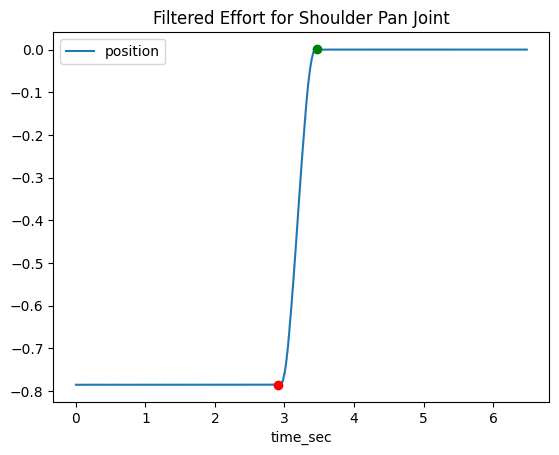

In [60]:
df[df['joint_name'] == 'shoulder_pan_joint'].plot(x='time_sec', y='position', title='Filtered Effort for Shoulder Pan Joint')
plt.plot(start_point['time_sec'], start_point['position'], 'ro', label='Start Point')
plt.plot(end_point['time_sec'], end_point['position'], 'go', label='End Point')

<Axes: title={'center': 'Filtered Effort for Shoulder Pan Joint'}, xlabel='time_sec'>

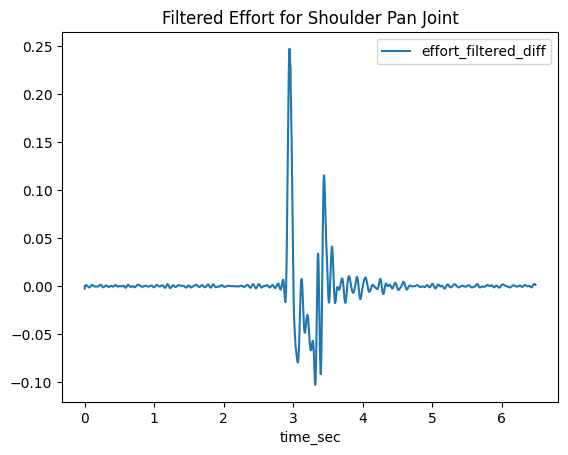

In [54]:
df[df['joint_name'] == 'shoulder_pan_joint'].plot(x='time_sec', y='effort_filtered_diff', title='Filtered Effort for Shoulder Pan Joint')


In [33]:
if 'df' in globals() and not df.empty and diff_col in df.columns:
    fig_effort_diff = px.line(
        df,
        x='time_sec',
        y=diff_col,
        color='joint_name',
        title=f"Per-Joint Change in Filtered Effort",
        labels={'time_sec': 'Time (s)', diff_col: 'Change in Effort'}
    )
    fig_effort_diff.show()
else:
    print("DataFrame 'df' is empty or required columns are missing.")